In [1]:
#  Setup and Input Directory Detection
import os

# Automatically detect base project directory
base_dir = os.getcwd()
print(f"Base project directory: {base_dir}")


Base project directory: /home/lucianghiba/MSc_Project


In [2]:
# Standard Library 
import os                    # Provides functions to interact with the operating system (file paths, directories, etc.)
import re                    # Regular expressions for pattern matching and string parsing
import sys                   # System-specific parameters and functions (e.g., command-line args, exit)
import tarfile               # Read and write .tar and .tar.gz/.tgz archive files
import time                  # Time tracking functions (e.g., sleep, time stamps)
import json                  # Reading/writing JSON files
import math                  # Basic mathematical functions (e.g., sqrt, floor)
import glob                  # File path matching using wildcards (e.g., *.pdb)
import subprocess            # Run external shell commands (e.g., bash scripts)
from math import sqrt        # Import just the sqrt function from the math module
from pathlib import Path     # Object-oriented file system paths
from datetime import datetime  # For timestamping and tracking dates
from urllib.parse import urljoin  # Join base and relative URLs correctly

# Data Handling and Visualisation 
import numpy as np           # Numerical computing with arrays and matrices
import pandas as pd          # DataFrames for tabular data manipulation
import matplotlib.pyplot as plt  # Plotting graphs and figures
import seaborn as sns        # Advanced plotting library built on top of matplotlib

# Jupyter Integration & Widgets 
from IPython.display import display, clear_output  # Display widgets and control output updates
import ipywidgets as widgets                      # Interactive widgets (dropdowns, sliders, etc.)
from tqdm.notebook import tqdm                    # Progress bar optimised for Jupyter notebooks
from termcolor import cprint, colored             # Colored terminal output (for emphasis/debug)

# Biopython for PDB Parsing and Sequence Handling 
from Bio import SeqIO                              # Sequence file parsing (FASTA, GenBank, etc.)
from Bio.PDB import (                              # PDB structure parsing and analysis
    PDBList,                                        # Download PDB files from RCSB
    PDBParser,                                      # Parse PDB file content into structure objects
    Selection,                                      # Select atoms/residues/chains from structures
    NeighborSearch                                  # Search for atoms within a radius
)

# RDKit: Cheminformatics Toolkit 
from rdkit import Chem                              # Core chemistry functionality (molecules, atoms)
from rdkit import RDLogger                          # Logger for suppressing RDKit warnings
from rdkit.Chem import (                            # Import common chemistry modules
    Descriptors,                                    # Molecular property descriptors (e.g., weight, PSA)
    Crippen,                                        # LogP, MR estimations
    Lipinski,                                       # Rule of 5 checks
    AllChem,                                        # 3D generation, optimization, force fields
    SDWriter,                                       # Write molecules to .sdf format
    Draw,                                           # 2D drawing tools
    rdMolDescriptors                                # Molecular weight, atom count, etc.
)
from rdkit.Chem.Draw import MolsToGridImage         # Display multiple molecules in a grid

# 3D Structure & Geometry Analysis 
import py3Dmol                                       # Interactive 3D molecular viewer (browser-based)
from scipy.spatial.distance import euclidean         # Calculate Euclidean distance between coordinates

# Confirm Dependencies Are Working 
try:
    parser = PDBParser(QUIET=True)                   # Create PDB parser instance without warnings
    mol = Chem.MolFromSmiles("CCO")                  # Test RDKit by converting ethanol SMILES to molecule
    print("Biopython and RDKit are working.")        # Success message
    print("Biopython version:", SeqIO.__doc__.split()[-1])  # Print version info from Biopython docstring
except Exception as e:
    print("Dependency check failed:", e)             # Print any error encountered


Biopython and RDKit are working.
Biopython version: SeqRecords.


Step 0 : Environment Setup and Dependency Check

In [3]:
# Display a friendly welcome message with an emoji for clarity
print("Welcome to the Ligand-Pocket Filtering Pipeline!")

# Use colored terminal output (if `cprint` is defined from termcolor) to show purpose of the tool
cprint("This tool will help you explore protein structures and find potential binding pockets.\n", "blue")

# === Step 0: Show current working directory and allow user to confirm or choose a different one ===

# Get the current working directory
cwd = os.getcwd()

# Print current directory to userpdb_dir
print(f"You are currently working in this directory:\n{cwd}\n")

# Ask user whether they want to use the current directory
use_current = input("Do you want to use this directory to store/download your files? (yes/no): ").strip().lower()

# If user confirms, use current directory as the base project directory
if use_current == "yes":
    base_dir = cwd
    print(f"All files will be stored in: {base_dir}\n")

else:
    # Prompt user for a custom folder path with platform-specific examples
    print("\nYou can enter a full folder path like:")
    print(" Windows: C:\\Users\\YourName\\MyProject")
    print(" macOS/Linux: /home/yourname/MyProject")

    # Warn user that spaces in folder paths can break Fpocket execution on Linux
    print("IMPORTANT: Please avoid using folders with spaces in the name.")
    print("Fpocket (which runs in Linux) may fail if the folder name has spaces.\n")

    # Loop until a valid folder path is entered
    while True:
        # Ask user to manually enter desired working directory
        base_dir = input("Enter the full path of the directory you'd like to use: ").strip()

        # Reject paths with spaces due to known compatibility issues with Fpocket
        if " " in base_dir:
            print("The folder path contains spaces, which can break Fpocket.")
            print("Please rename the folder or choose a different one without spaces.\n")
            continue

        # Check if folder actually exists on disk
        if os.path.isdir(base_dir):
            print(f"Directory exists: {base_dir}")

            # Confirm again before proceeding
            confirm = input("Are you sure you want to use this directory? (yes/no): ").strip().lower()
            if confirm == "yes":
                break  # Exit loop if confirmed
            else:
                print("Let's try again.")  # Retry if not confirmed

        else:
            # Inform user that folder must exist beforehand
            print(f"That directory doesn't exist.\nPlease create it first or enter a different one.\n")

# Create a subdirectory inside base_dir for storing downloaded PDB files
pdb_dir = os.path.join(base_dir, "pdb_files")

# Create the folder if it doesn't already exist
os.makedirs(pdb_dir, exist_ok=True)

# Notify user of the final directory location for downloaded PDBs
cprint(f"All downloaded PDB files will be stored in:\n{pdb_dir}\n", "green")

Welcome to the Ligand-Pocket Filtering Pipeline!
This tool will help you explore protein structures and find potential binding pockets.

You are currently working in this directory:
/home/lucianghiba/MSc_Project



Do you want to use this directory to store/download your files? (yes/no):  yes


All files will be stored in: /home/lucianghiba/MSc_Project

All downloaded PDB files will be stored in:
/home/lucianghiba/MSc_Project/pdb_files



Step 1 : Load PDB Structure, Detect Ligands, and Select Pocket Info File

In [4]:
print("\nStarting Ligand-Pocket Analysis...\n")  # Print a header to indicate the start of the analysis process

# === Step 1: Get PDB ID and download ===
pdb_id = input("Enter the PDB ID of the protein you want to analyze (e.g., 3L3N): ").strip().upper()  # Prompt user for a PDB ID, remove whitespace, and convert to uppercase
print(f"You entered PDB ID: {pdb_id}")  # Confirm the user's input

cprint(f"Downloading structure {pdb_id.upper()} from the Protein Data Bank...", "yellow")  # Notify user that structure download is starting
pdbl = PDBList()  # Create a PDBList object from BioPython to handle downloading
downloaded_path = pdbl.retrieve_pdb_file(pdb_id, pdir=pdb_dir, file_format="pdb")  # Download the PDB file into the specified directory

# Fix Biopython naming
expected_path = os.path.join(pdb_dir, f"pdb{pdb_id.lower()}.ent")  # Define the expected file path for the downloaded structure
if not os.path.exists(expected_path):  # Check if the expected file does not already exist
    os.rename(downloaded_path, expected_path)  # Rename the downloaded file to match the expected format
pdb_file_path = expected_path  # Store the path to the correctly named PDB file

# Convert .ent to .pdb
converted_pdb_path = os.path.join(pdb_dir, f"{pdb_id}.pdb")  # Define the path for the converted .pdb file
if not os.path.exists(converted_pdb_path):  # Only convert if the .pdb version does not already exist
    with open(pdb_file_path, "r") as infile, open(converted_pdb_path, "w") as outfile:  # Open input and output files
        for line in infile:  # Loop through each line in the input file
            if line.startswith(("ATOM", "HETATM", "TER", "END")):  # Keep only relevant structure lines
                outfile.write(line)  # Write filtered line to output
    cprint(f"Structure saved to {converted_pdb_path}\n", "green")  # Confirm successful save
else:
    cprint(f"PDB file already exists at:\n  {converted_pdb_path}", "red")  # Warn if file already exists and skip

# === Step 2: Parse structure and identify ligands ===
parser = PDBParser(QUIET=True)  # Create a parser object with quiet mode to suppress warnings
structure = parser.get_structure(pdb_id, converted_pdb_path)  # Parse the structure from the converted PDB file

print("\nScanning structure for ligand-like residues...")  # Notify that ligand search is starting
het_residues = []  # List to store non-standard residues (e.g., ligands)
unique_ligands = set()  # Set to store unique ligand residue names

for chain in structure[0]:  # Loop over all chains in the first model of the structure
    for residue in chain:  # Loop over all residues in each chain
        hetflag = residue.id[0]  # Extract the hetero-flag, which identifies non-standard residues
        resname = residue.get_resname().strip().upper()  # Get residue name, trim spaces, and convert to uppercase
        if hetflag != " ":  # If the residue is not a standard amino acid (i.e., it is a ligand, water, or ion)
            het_residues.append(residue)  # Add the residue to the list of hetero-residues
            unique_ligands.add(resname)  # Add the ligand name to the set of unique ligands
            print(f"  → Found: {resname}")  # Print each ligand found

if not unique_ligands:  # If no ligands were found
    print("No ligand-like residues found.")  # Notify user
else:
    print("Summary of Unique Ligands Found:")  # Print header for summary
    for ligand in sorted(unique_ligands):  # Loop through the sorted set of ligand names
        print(f" - {ligand}")  # Print each ligand name

# Save ligand info for reuse in Step 2
ligand_dict = {}  # Initialize (or reset) an empty dictionary to store ligand names and their 3D centroids

# Loop through each HET (non-standard) residue, which likely includes ligands, ions, etc.
for residue in het_residues:
    resname = residue.get_resname().strip().upper()  # Get and clean the residue (ligand) name, e.g. 'LSW'
    
    # Extract the coordinates of all non-hydrogen atoms in the ligand
    atoms = [atom.get_coord() for atom in residue.get_atoms() if atom.element != "H"]
    
    # If any atoms remain (i.e., the ligand has non-H atoms)
    if atoms:
        centroid = np.mean(atoms, axis=0)  # Compute the 3D centroid of the ligand by averaging its atom coordinates
        ligand_dict[resname] = centroid    # Store the ligand name and its centroid in the dictionary

# Optionally display the result for verification or debugging
print("Ligand Centroid Dictionary:")
for name, coords in ligand_dict.items():  # Loop over each ligand and its centroid
    rounded_coords = tuple(float(round(x, 2)) for x in coords)  # Round each coordinate to 2 decimal places for display
    print(f"{name}: {rounded_coords}")  # Print the ligand name and its rounded centroid coordinates



Starting Ligand-Pocket Analysis...



Enter the PDB ID of the protein you want to analyze (e.g., 3L3N):  3L3N


You entered PDB ID: 3L3N
Structure saved to /home/lucianghiba/MSc_Project/pdb_files/3L3N.pdb


Scanning structure for ligand-like residues...
  → Found: ZN
  → Found: CL
  → Found: CL
  → Found: LSW
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Found: HOH
  → Fo

In [5]:
# Fpocket Run

# Confirm if the converted PDB file exists
if not os.path.isfile(converted_pdb_path):  # Check if the expected PDB file path exists
    cprint(f"The converted PDB file was not found at:\n  {converted_pdb_path}", "red")  # Print error in red if file is missing
    cprint("Please re-run Step 1 to download and convert the PDB file.", "red")  # Suggest corrective action
    raise FileNotFoundError("PDB file missing. Cannot proceed to Fpocket.")  # Stop the script with an explicit error
else:
    cprint(f"PDB file found at:\n  {converted_pdb_path}", "green")  # Confirm file exists (print in green)
    
    # Ask the user if they want to proceed with Fpocket
    user_choice = input("Do you want to run Fpocket on this file now? (yes/no): ").strip().lower()  # Get user input and normalize
    if user_choice not in ["yes", "y"]:  # If user declines, skip running Fpocket
        cprint("Skipping Fpocket. You can re-run Step 1 if needed.", "yellow")  # Print warning in yellow
    else:
        # Define a function to run Fpocket on a given PDB file path
        def run_fpocket(pdb_path):
            cprint(f"🛠️ Running Fpocket on:\n  {pdb_path}", "blue")  # Announce execution
            try:
                result = subprocess.run(  # Run the Fpocket command-line tool using subprocess
                    ["fpocket", "-f", pdb_path],  # Fpocket command with the input file
                    check=True,  # Raise error if command fails
                    capture_output=True,  # Capture stdout and stderr
                    text=True  # Return output as string (not bytes)
                )
                cprint("Fpocket completed successfully!", "green")  # Confirm success
                cprint("Last lines from Fpocket output:\n", "blue")  # Show some output from Fpocket
                print("\n".join(result.stdout.splitlines()[-10:]))  # Print the last 10 lines of output
            except subprocess.CalledProcessError as e:  # Catch any error if Fpocket fails
                cprint("[ERROR] Fpocket failed.", "red")  # Show failure message
                print(e.stderr)  # Print error details

        # Run the Fpocket function with the provided PDB path
        run_fpocket(converted_pdb_path)


PDB file found at:
  /home/lucianghiba/MSc_Project/pdb_files/3L3N.pdb


Do you want to run Fpocket on this file now? (yes/no):  yes


🛠️ Running Fpocket on:
  /home/lucianghiba/MSc_Project/pdb_files/3L3N.pdb
Fpocket completed successfully!
Last lines from Fpocket output:

***** POCKET HUNTING BEGINS ***** 
***** POCKET HUNTING ENDS ***** 


Step 2: Pocket Selection (Ligand / Residue / Largest Volume)

In [6]:
# STEP 2 — Select Pocket by Ligand, Residue, or Auto

# 2.1 Load Fpocket Summary Info 

# Function to extract pocket information (IDs and centers) from the Fpocket _info.txt file
def parse_fpocket_summary(info_file):
    pockets = []  # Initialize empty list to store each pocket's information
    pocket = {}   # Temporary dictionary to hold info for one pocket at a time
    with open(info_file, 'r') as f:  # Open the summary info file
        for line in f:
            line = line.strip()  # Remove leading/trailing whitespace
            if line.startswith("Pocket"):  # Found a new pocket entry
                if pocket:  # If previous pocket is not empty, add it to the list
                    pockets.append(pocket)
                pocket = {"id": int(line.split()[1])}  # Extract and store pocket ID
            elif line.startswith("Center :"):  # Found center coordinates
                parts = line.split(":")[1].strip().split()  # Split by ':' and then whitespace
                try:
                    pocket["center"] = tuple(map(float, parts))  # Convert center coordinates to float tuple
                except ValueError:
                    pocket["center"] = None  # If parsing fails, set to None
        if pocket:
            pockets.append(pocket)  # Append last pocket
    return pockets  # Return list of parsed pockets

# Function to load atoms for each pocket by reading the pocket PDB file
def attach_pocket_atoms(pockets, pocket_dir):
    parser = PDBParser(QUIET=True)  # Create a PDB parser (QUIET suppresses warnings)
    for i, pocket in enumerate(pockets):  # Loop over all pockets
        pocket_file = os.path.join(pocket_dir, f"pocket{i+1}_atm.pdb")  # Construct path to pocket PDB
        if os.path.exists(pocket_file):  # Check if file exists
            structure = parser.get_structure(f"pocket_{i+1}", pocket_file)  # Parse the pocket structure
            pocket["atoms"] = list(structure.get_atoms())  # Store atoms in the pocket dictionary
            print(f"Pocket {i+1}: {len(pocket['atoms'])} atoms loaded.")  # Print success
        else:
            pocket["atoms"] = []  # If file not found, set empty list
            print(f"Pocket {i+1}: File not found -> {pocket_file}")  # Warn user

# 2.2 Auto-load input files from base_dir 

# Find the first .pdb file in the pdb_files folder
pdb_file = [f for f in os.listdir(os.path.join(base_dir, "pdb_files")) if f.endswith(".pdb")][0]

# Extract the PDB ID by removing file extension and "_out"
pdb_id = pdb_file.split(".")[0].replace("_out", "")

# Construct full path to the converted .pdb file (from Fpocket)
converted_pdb_path = os.path.join(base_dir, "pdb_files", f"{pdb_id}_out", f"{pdb_id}_out.pdb")

# Construct full path to the summary _info.txt file
info_file = os.path.join(base_dir, "pdb_files", f"{pdb_id}_out", f"{pdb_id}_info.txt")

# Construct path to the directory containing individual pocket files
pocket_dir = os.path.join(base_dir, "pdb_files", f"{pdb_id}_out", "pockets")

# 2.3 Load and Annotate Pockets 

# Parse the summary info file and get pocket list with center info
pockets = parse_fpocket_summary(info_file)

# Attach atom coordinates to each pocket by reading their PDBs
attach_pocket_atoms(pockets, pocket_dir)

# Recalculate center coordinates based on atom positions (for accuracy)
for pocket in pockets:
    atoms = pocket.get("atoms", [])
    if atoms:
        coords = [atom.coord for atom in atoms]  # List of atom coordinates
        pocket["center"] = tuple(np.mean(coords, axis=0))  # Average all atom coords to get center
    else:
        pocket["center"] = (0.0, 0.0, 0.0)  # Default value if no atoms

# 2.4 Visualise Pockets on Structure 

# Initialize Py3Dmol viewer with width and height
viewer = py3Dmol.view(width=800, height=600)

# Load the full protein model from the PDB file
viewer.addModel(open(converted_pdb_path).read(), "pdb")

# Set the protein style to colored cartoon
viewer.setStyle({'cartoon': {'color': 'spectrum'}})

# Add each pocket as a blue transparent sphere and label it
for pocket in pockets:
    x, y, z = map(float, pocket["center"])  # Ensure coordinates are floats
    viewer.addSphere({'center': {'x': x, 'y': y, 'z': z}, 'radius': 1.0, 'color': 'blue', 'opacity': 0.3})
    viewer.addLabel(f"P{pocket['id']}", {'position': {'x': x, 'y': y, 'z': z}, 'fontSize': 12, 'backgroundColor': 'lightgray'})

# Fit the view to show all models
viewer.zoomTo()

# Show the viewer
viewer.show()

# 2.5 Prompt for Pocket Selection Strategy 

# Print instructions for pocket selection options
cprint("Step 2: Choose Pocket by Ligand or Residue ===", "blue")
print("1️⃣  Use ligand centroid")
print("2️⃣  Use key amino acids")
print("3️⃣  Auto-select the largest pocket")

# Ask user for their selection method
selection_method = input("Enter your choice (1, 2, or 3): ").strip()

# 2.6 Load Structure & Prepare Hetero Residues 

# Ask user if they want to include water molecules (HOH)
include_water = input("Include water molecules (HOH)? (yes/no): ").strip().lower() == "yes"

# Ask if they want to include zinc ions (ZN)
include_zinc = input("Include zinc ions (ZN)? (yes/no): ").strip().lower() == "yes"

# Load the structure using BioPython PDBParser
parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", converted_pdb_path)

# Get hetero residues (ligands, water, metals), filtered by inclusion flags
het_residues = [
    res for chain in structure[0] for res in chain
    if res.id[0].startswith("H_") and (
        include_water or res.get_resname().strip() != "HOH"
    ) and (
        include_zinc or res.get_resname().strip() != "ZN"
    )
]


# 2.7 Pocket Selection Logic 

# Initialize variables to hold selection results
final_pocket = None                # The final selected pocket object
accepted_pockets = []             # Pocket(s) with extra metadata (for residues)
ligand_id = None                  # ID of selected ligand (if applicable)
important_residues = []           # List of matched residues (for residue selection)

# Ligand-based Pocket Selection
if selection_method == "1":
    ligands = sorted(ligand_dict.keys())  # Get sorted list of available ligand IDs
    if ligands:
        print("Available ligands:")  # Show ligand options to user
        for i, lig in enumerate(ligands, 1):  # Enumerate ligand list with index
            print(f"  {i}. {lig}")
        # Prompt user to select ligand by number or name
        choice = input("Select a ligand (number or code): ").strip().upper()
        # Convert number to ligand ID or use name directly
        ligand_id = ligands[int(choice) - 1] if choice.isdigit() and 0 < int(choice) <= len(ligands) else choice
        cprint(f"Ligand selected: {ligand_id}", "green")  # Confirm selection

        # If ligand exists in the dictionary, continue
        if ligand_id in ligand_dict:
            centroid = ligand_dict[ligand_id]  # Get centroid of selected ligand
            # Find the closest pocket to the ligand centroid
            final_pocket = min(pockets, key=lambda p: euclidean(p["center"], centroid))
            accepted_pockets = [{
                "pocket": final_pocket,
                "centroid": final_pocket["center"],
                "residues": []
            }]
            cprint(f"Closest pocket: Pocket ID {final_pocket['id']}", "blue")
        else:
            # Fallback if ligand not found
            cprint("Ligand centroid not found. Falling back to largest pocket.", "yellow")
            selection_method = "3"
    else:
        # Fallback if no ligands available
        cprint("No ligands found. Falling back to largest pocket.", "yellow")
        selection_method = "3"

# Residue-based Pocket Selection 
if selection_method == "2":
    # Create list of all residue names and numbers
    residue_list = [
        f"{res.get_resname().strip()}{res.id[1]}"
        for chain in structure[0]
        for res in chain if res.id[0] == " "
    ]
    print("\n🧬 Available residues:\n" + ", ".join(residue_list))  # Show user the residue options

    # Prompt user to enter residues of interest
    res_input = input("Enter important residues (e.g., HIS57, 57, GLU520): ")

    # Extract residue numbers from input
    res_ids = [int(''.join(filter(str.isdigit, x))) for x in res_input.replace(" ", "").split(",") if ''.join(filter(str.isdigit, x)).isdigit()]

    # Use NeighborSearch to find atoms within 5 Å of pocket centers
    ns = NeighborSearch(Selection.unfold_entities(structure[0], 'A'))
    matched_pockets = []  # To store pockets near important residues

    for pocket in pockets:
        atoms = pocket.get("atoms", [])
        if not atoms:
            continue
        nearby_atoms = ns.search(pocket["center"], 5.0)  # Atoms within 5Å of center
        residues_nearby = {a.get_parent() for a in nearby_atoms if a.get_parent().id[0] == " "}
        
        # Match residues by ID and construct info with name and centroid
        matched = [
            {
                "id": res.id[1],
                "resname": res.get_resname().strip(),
                "centroid": tuple(np.mean([atom.coord for atom in res], axis=0))
            }
            for res in residues_nearby if res.id[1] in res_ids
        ]

        if matched:
            matched_pockets.append({
                "pocket": pocket,
                "matched_residues": matched
            })

    # If matching pockets were found, select the first one
    if matched_pockets:
        final_pocket = matched_pockets[0]["pocket"]
        accepted_pockets = [{
            "pocket": final_pocket,
            "centroid": final_pocket["center"],
            "residues": matched_pockets[0]["matched_residues"]
        }]
        cprint(f"Closest matched pocket: Pocket ID {final_pocket['id']}", "blue")
    else:
        # Fallback to largest pocket if no matches found
        cprint("No pockets matched residues. Falling back to largest pocket.", "red")
        selection_method = "3"

# Auto-selection of Largest Pocket 
if not final_pocket and selection_method == "3":
    # Pick pocket with the highest volume (fallback default)
    final_pocket = max(pockets, key=lambda p: p.get("volume", 0))
    accepted_pockets = [{
        "pocket": final_pocket,
        "centroid": final_pocket["center"],
        "residues": []
    }]
    cprint(f"Largest pocket selected: Pocket ID {final_pocket['id']}", "green")

# 2.8.1 Safeguard: Ensure pocket["center"] is not None 

# If for any reason the pocket center is invalid, recalculate it from atoms
if final_pocket["center"] is None or not isinstance(final_pocket["center"], tuple):
    atoms = final_pocket.get("atoms", [])
    if atoms:
        coords = [atom.coord for atom in atoms]  # Get coordinates of all atoms
        final_pocket["center"] = tuple(np.mean(coords, axis=0))  # Calculate average
    else:
        final_pocket["center"] = (0.0, 0.0, 0.0)  # Default fallback center


# 2.8.1 Safeguard: Ensure pocket["center"] is not None 

# Check if the selected pocket's center is missing or invalid (not a tuple)
if final_pocket["center"] is None or not isinstance(final_pocket["center"], tuple):
    # Try to get the atom list from the final pocket (may be empty or missing)
    atoms = final_pocket.get("atoms", [])
    
    # If atom coordinates are available
    if atoms:
        # Extract 3D coordinates from each atom
        coords = [atom.coord for atom in atoms]
        
        # Calculate the mean of all coordinates to get an approximate center
        final_pocket["center"] = tuple(np.mean(coords, axis=0))
    else:
        # If no atoms are available, fall back to default placeholder center
        final_pocket["center"] = (0.0, 0.0, 0.0)


# 2.9 Final Outputs for Pipeline 

# Get the final pocket center as a tuple of floats for consistency
pocket_centroid = tuple(float(x) for x in final_pocket["center"])

# If a ligand was selected, get its centroid from ligand_dict (or None if not selected)
ligand_centroid = tuple(float(x) for x in ligand_dict.get(ligand_id)) if ligand_id else None

# For each selected residue, extract the precomputed centroid directly
residue_centroids = [
    tuple(float(x) for x in res["centroid"])
    for res in accepted_pockets[0]["residues"]
] if accepted_pockets and accepted_pockets[0]["residues"] else []

# Package all selection data into a dictionary to pass between steps
selection_state = {
    "pocket_id": final_pocket["id"],                        # ID of the selected pocket
    "pocket_centroid": pocket_centroid,                    # Pocket center coordinates
    "ligand_id": ligand_id,                                # ID of the selected ligand (if any)
    "ligand_centroid": ligand_centroid,                    # Ligand centroid (if applicable)
    "residues": accepted_pockets[0]["residues"]            # List of selected residues (if any)
    if accepted_pockets and accepted_pockets[0]["residues"] else []
}

# 2.10 Save Selection for Downstream Use 

# Construct a summary dictionary of key pocket properties
selected_pocket_summary = {
    "final_pocket_id": final_pocket["id"],                      # Pocket ID
    "centroid": list(pocket_centroid),                          # Center (as a list for JSON compatibility)
    "volume_mc": final_pocket.get("volume_mc"),                 # Volume (molecular cavity)
    "volume_ch": final_pocket.get("volume_ch"),                 # Volume (convex hull)
    "hydrophobicity_score": final_pocket.get("hydrophobicity_score"),  # Hydrophobicity score
    "logp_estimate": final_pocket.get("logp_estimate"),         # Estimated logP (optional)
    "heavy_atom_estimate": final_pocket.get("heavy_atom_estimate"),    # Estimated heavy atom count
    "max_density": final_pocket.get("max_density"),             # Max pocket atom density
    "safety_margin": final_pocket.get("safety_margin")          # Optional safety/space margin
}

# Write this dictionary to a JSON file so it can be reused in later steps
with open("selected_pocket_summary.json", "w") as f:
    json.dump(selected_pocket_summary, f, indent=4)

# Print confirmation:

# Print header with cyan color to highlight summary section
cprint("Final Selection Summary", "cyan")

# Display selected pocket ID
print(f"Pocket ID: {selection_state['pocket_id']}")

# Display selected pocket center coordinates
print(f"Pocket Centroid: {selection_state['pocket_centroid']}")

# If a ligand was selected, print its ID and centroid
if selection_state["ligand_id"]:
    print(f"Ligand Selected: {selection_state['ligand_id']} with centroid {selection_state['ligand_centroid']}")

# If residues were selected, print their names and positions
if selection_state["residues"]:
    residue_summaries = [
        f"{res['resname']}{res['id']}" for res in selection_state["residues"]
    ]
    print(f"Residues Selected: {residue_summaries}")


Pocket 1: 348 atoms loaded.
Pocket 2: 18 atoms loaded.
Pocket 3: 31 atoms loaded.
Pocket 4: 19 atoms loaded.
Pocket 5: 17 atoms loaded.
Pocket 6: 18 atoms loaded.
Pocket 7: 21 atoms loaded.
Pocket 8: 14 atoms loaded.
Pocket 9: 24 atoms loaded.
Pocket 10: 16 atoms loaded.
Pocket 11: 27 atoms loaded.
Pocket 12: 14 atoms loaded.
Pocket 13: 12 atoms loaded.
Pocket 14: 13 atoms loaded.
Pocket 15: 20 atoms loaded.
Pocket 16: 36 atoms loaded.
Pocket 17: 29 atoms loaded.
Pocket 18: 16 atoms loaded.
Pocket 19: 22 atoms loaded.
Pocket 20: 25 atoms loaded.
Pocket 21: 37 atoms loaded.
Pocket 22: 17 atoms loaded.
Pocket 23: 17 atoms loaded.
Pocket 24: 36 atoms loaded.
Pocket 25: 15 atoms loaded.
Pocket 26: 27 atoms loaded.
Pocket 27: 27 atoms loaded.
Pocket 28: 17 atoms loaded.
Pocket 29: 16 atoms loaded.
Pocket 30: 36 atoms loaded.
Pocket 31: 33 atoms loaded.


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Step 2: Choose Pocket by Ligand or Residue ===
1️⃣  Use ligand centroid
2️⃣  Use key amino acids
3️⃣  Auto-select the largest pocket


Enter your choice (1, 2, or 3):  1
Include water molecules (HOH)? (yes/no):  no
Include zinc ions (ZN)? (yes/no):  no


Available ligands:
  1. CL
  2. FUC
  3. HOH
  4. LSW
  5. NAG
  6. ZN


Select a ligand (number or code):  4


Ligand selected: LSW
Closest pocket: Pocket ID 1
Final Selection Summary
Pocket ID: 1
Pocket Centroid: (41.6887092590332, 5.206746578216553, 111.88990783691406)
Ligand Selected: LSW with centroid (42.844703674316406, 8.113612174987793, 112.1882553100586)


Step 3 : Helper Functions for Distance and Centroid Calculations

In [7]:
# === STEP 3 — Helper Functions for Distance and Centroid Calculations ========

def calculate_centroid(atom_list):
    if not atom_list: # If the atom list is empty or None, return a default point at the origin
        return (0.0, 0.0, 0.0)
    coords = [atom.coord for atom in atom_list]  # Extract the 3D coordinates (atom.coord) for each atom in the list
    return tuple(sum(c[i] for c in coords) / len(coords) for i in range(3)) # Compute the average of x, y, and z coordinates separately using a generator expression
    # sum(c[i] for c in coords) adds all x's (i=0), y's (i=1), and z's (i=2) and divides by the number of atoms

# This function calculates the Euclidean distance between two 3D coordinate points.
def calculate_distance(coord1, coord2):
    # Uses scipy.spatial.distance.euclidean or a custom euclidean() function
    return euclidean(coord1, coord2)

# This function displays the label and coordinates of a given centroid in the terminal.
def display_centroid(label, coord):
    # Unpack the tuple (x, y, z) into individual variables
    x, y, z = coord
    
    # Print the label along with the centroid coordinates rounded to 2 decimal places
    print(f"{label} Centroid: x={x:.2f}, y={y:.2f}, z={z:.2f}")

Step 4 : Load Pocket Summary File from Fpocket Output

In [8]:
fpocket_folder = os.path.join(pdb_dir, f"{pdb_id}_out")  # Construct path to the Fpocket output folder using the PDB ID
cprint(f" Looking for Fpocket summary in:\n  {fpocket_folder}", "blue")  # Print message showing the folder being checked

if not os.path.isdir(fpocket_folder):  # Check if the folder actually exists
    cprint(f"Fpocket output folder not found: {fpocket_folder}", "red")  # Show error if folder is missing
    exit()  # Exit the script if the folder doesn't exist

txt_files = [f for f in os.listdir(fpocket_folder) if f.endswith("_info.txt")]  # Look for all files ending in "_info.txt" (summary files)

if not txt_files:  # If no summary files are found
    cprint(f"No _info.txt file found in:\n  {fpocket_folder}", "red")  # Print error message
    exit()  # Exit the script as no valid Fpocket summary is available
else:
    info_file = txt_files[0]  # Take the first summary file found (assumes only one exists)
    info_path = os.path.join(fpocket_folder, info_file)  # Build full path to the selected summary file
    cprint(f"Using Fpocket summary file: {info_file}", "cyan")  # Notify the user which summary file is being used

    with open(info_path) as f:  # Open the summary file
        lines = f.readlines()  # Read all lines from the file
        preview = "".join(lines[:10]) if len(lines) >= 10 else "".join(lines)  # Preview the first 10 lines (or all if fewer)
        print("\nFpocket Summary Preview:")  # Header for the preview
        print("---------------------------------")  # Separator
        print(preview.strip())  # Print the preview content without extra blank lines
        print("---------------------------------")  # Footer line for preview


 Looking for Fpocket summary in:
  /home/lucianghiba/MSc_Project/pdb_files/3L3N_out
Using Fpocket summary file: 3L3N_info.txt

Fpocket Summary Preview:
---------------------------------
Pocket 1 :
	Score : 	2.652
	Druggability Score : 	0.988
	Number of Alpha Spheres : 	621
	Total SASA : 	1491.278
	Polar SASA : 	717.287
	Apolar SASA : 	773.991
	Volume : 	5448.034
	Mean local hydrophobic density : 	25.941
	Mean alpha sphere radius :	3.951
---------------------------------


Step 5 : Parse Pocket Summary File and Extract Pocket Info

In [9]:
# Step 5: Parsing Fpocket Summary File
cprint("Parsing Fpocket Summary File", "blue")  # Print header for this step in blue

# Feature dictionary: maps display names (used in file) to internal keys for parsed pocket dictionaries
feature_options = {
    "volume": "volume",                             # Pocket's physical size in Å³
    "volume score": "volume_score",                 # Internal Fpocket quality score for pocket volume
    "druggability score": "druggability",           # Likelihood that the pocket can bind drug-like molecules
    "polarity score": "polarity",                   # Degree of polarity (e.g., polar side chains)
    "hydrophobicity score": "hydrophobicity",       # Hydrophobicity of the pocket environment
    "number of alpha spheres": "alpha_spheres",     # Geometric descriptor — used by Fpocket to define pocket volume
}

# Display the available features
cprint("These are the most useful features extracted from the Fpocket summary file:", "blue")  # Notify user of feature options
for i, (label, _) in enumerate(feature_options.items(), start=1):  # Loop through and number each feature
    print(f"  {i}. {label.title()}")  # Print each feature name with title casing

# User choice: manual or default features
cprint("If unsure, type 'no' to use default features.", "blue")  # Suggest default to unsure users
choice = input("Would you like to choose which features to extract? (yes/no): ").strip().lower()  # Ask user to choose features manually or not

if choice == "yes":  # If user wants to choose
    selected_features = input("Enter feature names (e.g., Volume, Volume Score):\n").split(',')  # Prompt input
    selected_features = [f.strip().lower() for f in selected_features if f.strip().lower() in feature_options]  # Validate and normalize selection
    if not selected_features:  # If no valid input
        cprint("No valid features selected. Using defaults.\n", "blue")  # Warn and revert to default
        selected_features = list(feature_options.keys())  # Use all features
else:  # If user types no or presses enter
    cprint("Default feature set selected:", "green")  # Confirm default
    print("   Volume, Druggability Score, Polarity Score, Hydrophobicity Score, Alpha Spheres, Volume Score\n")  # Show default features
    selected_features = list(feature_options.keys())  # Use all features

# === Actual Parsing of the Fpocket *_info.txt Summary File ===
pockets = []              # List to hold parsed pocket dictionaries
current_pocket = None     # Temporary dictionary to store info while reading a pocket block

with open(info_path, "r") as f:  # Open the Fpocket summary file
    for line in f:  # Loop through each line
        line = line.strip()  # Remove leading/trailing whitespace

        # Start of a new pocket block (e.g., "Pocket 1 :")
        if line.lower().startswith("pocket") and ":" in line:  # Detect pocket section header
            pocket_number = int(line.split()[1].strip(":"))  # Extract pocket number
            current_pocket = {"id": pocket_number}  # Initialize new pocket dictionary

        # Within a pocket block: extract relevant features
        elif current_pocket:  # Only parse if inside a pocket block
            for label, key in feature_options.items():  # Loop over feature dictionary
                if label in selected_features:  # Only look for selected features
                    pattern = re.compile(rf"^{label}\s*:\s*(.*)", re.IGNORECASE)  # Create regex to match 'Label : value'
                    match = pattern.match(line)  # Try to match the line
                    if match:  # If matched
                        try:
                            current_pocket[key] = float(match.group(1).strip())  # Convert the value to float and store
                        except Exception:
                            current_pocket[key] = None  # If conversion fails, store as None

        # End of block: if blank line and we were reading a pocket
        if line == "" and current_pocket:  # A blank line indicates the end of a pocket block
            pockets.append(current_pocket)  # Add the pocket to the list
            current_pocket = None  # Reset for the next block

# Append last pocket if not followed by newline
if current_pocket:  # If the file ended without a final blank line
    pockets.append(current_pocket)  # Add the last pocket to the list

# Output results
cprint(f"Parsed {len(pockets)} pockets from: {os.path.basename(info_path)}\n", "green")  # Print number of pockets found
for p in pockets:  # Loop through each pocket dictionary
    print(f"Pocket {p['id']}: ", end="")  # Print pocket ID
    for label in selected_features:  # Print each selected feature
        val = p.get(feature_options[label], "N/A")  # Get feature value or show "N/A"
        print(f"{label.title()} = {val}", end="  ")  # Print label and value
    print("")  # Newline after each pocket


Parsing Fpocket Summary File
These are the most useful features extracted from the Fpocket summary file:
  1. Volume
  2. Volume Score
  3. Druggability Score
  4. Polarity Score
  5. Hydrophobicity Score
  6. Number Of Alpha Spheres
If unsure, type 'no' to use default features.


Would you like to choose which features to extract? (yes/no):  


Default feature set selected:
   Volume, Druggability Score, Polarity Score, Hydrophobicity Score, Alpha Spheres, Volume Score

Parsed 31 pockets from: 3L3N_info.txt

Pocket 1: Volume = 5448.034  Volume Score = 4.19  Druggability Score = 0.988  Polarity Score = 76.0  Hydrophobicity Score = 19.05  Number Of Alpha Spheres = 621.0  
Pocket 2: Volume = 333.465  Volume Score = 5.333  Druggability Score = 0.0  Polarity Score = 4.0  Hydrophobicity Score = 13.333  Number Of Alpha Spheres = 19.0  
Pocket 3: Volume = 516.932  Volume Score = 4.357  Druggability Score = 0.003  Polarity Score = 10.0  Hydrophobicity Score = 17.929  Number Of Alpha Spheres = 43.0  
Pocket 4: Volume = 416.68  Volume Score = 4.125  Druggability Score = 0.004  Polarity Score = 5.0  Hydrophobicity Score = -25.25  Number Of Alpha Spheres = 15.0  
Pocket 5: Volume = 303.32  Volume Score = 4.571  Druggability Score = 0.0  Polarity Score = 5.0  Hydrophobicity Score = 15.857  Number Of Alpha Spheres = 20.0  
Pocket 6: Volume 

Step 6 : 3D Visualisation of Protein, Ligand, and Selected Pockets using py3Dmol

In [10]:
# STEP 6 – Visualize Pockets with Ligand and Residues

# Helper Functions 
def calculate_distance(coord1, coord2):
    return sqrt(sum((float(a) - float(b)) ** 2 for a, b in zip(coord1, coord2)))

def to_float_list(coord):
    return [float(x) for x in coord]

# File paths 
pocket_folder = os.path.join(pdb_dir, f"{pdb_id}_out")
pdb_file_path = os.path.join(pocket_folder, f"{pdb_id}_out.pdb")

# Centroid dictionaries 
pocket_centroids_dict = {}
if 'final_pocket' in globals() and final_pocket and "id" in final_pocket:
    pocket_centroids_dict[final_pocket["id"]] = to_float_list(final_pocket["center"])

residue_centroids_dict = {}
if 'accepted_pockets' in globals():
    for entry in accepted_pockets:
        for residue in entry.get("residues", []):
            if "id" in residue and "resname" in residue and "centroid" in residue:
                res_key = f"{residue['resname']}{residue['id']}"  # e.g., 'TYR523'
                residue_centroids_dict[res_key] = to_float_list(residue["centroid"])

ligand_centroid = None
if 'ligand_id' in globals() and ligand_id and 'ligand_dict' in globals():
    ligand_centroid = to_float_list(ligand_dict.get(ligand_id, [0, 0, 0]))

# Selection state
selection_state = {
    "pocket_id": final_pocket.get("id") if "final_pocket" in globals() else None,
    "pocket_centroid": final_pocket.get("center") if "final_pocket" in globals() else None,
    "ligand_id": ligand_id if "ligand_id" in globals() else None,
    "ligand_centroid": ligand_centroid if "ligand_centroid" in globals() else None,
    "residues": important_residues if "selection_method" in globals() and selection_method == "2" else []
}

# Viewer Function
def interactive_fpocket_viewer(protein_pdb_path, fpocket_folder,
                                pocket_ids_to_show=[],
                                selection_state=None,
                                pocket_centroids_dict=None,
                                residue_centroids_dict=None):

    viewer = py3Dmol.view(width=950, height=750)
    with open(protein_pdb_path, 'r') as f:
        viewer.addModel(f.read(), 'pdb')
    viewer.setStyle({'model': 0}, {'cartoon': {'color': 'spectrum'}})

    ligand_id = selection_state.get("ligand_id")
    ligand_centroid = selection_state.get("ligand_centroid")
    selected_residues = selection_state.get("residues", [])
    pocket_id = selection_state.get("pocket_id")

    model_index = 1
    for pid in pocket_ids_to_show:
        pocket_path = os.path.join(fpocket_folder, "pockets", f"pocket{pid}_atm.pdb")
        if os.path.exists(pocket_path):
            with open(pocket_path, 'r') as f:
                viewer.addModel(f.read(), 'pdb')
            viewer.setStyle({'model': model_index}, {
                'sphere': {'radius': 1.0, 'color': 'grey', 'opacity': 0.5}
            })

            if pocket_centroids_dict and pid in pocket_centroids_dict:
                pc = to_float_list(pocket_centroids_dict[pid])
                viewer.addLabel(f"Pocket {pid}", {
                    'position': {'x': pc[0], 'y': pc[1], 'z': pc[2]},
                    'backgroundColor': 'white',
                    'fontColor': 'black'
                })

                if pocket_id == pid:
                    viewer.addSphere({'center': dict(zip('xyz', pc)),
                                      'radius': 0.6,
                                      'color': 'red',
                                      'opacity': 1.0})

                    if ligand_centroid:
                        lc = to_float_list(ligand_centroid)
                        viewer.addLine({'start': dict(zip('xyz', pc)),
                                        'end': dict(zip('xyz', lc)),
                                        'color': 'purple'})
                        mid = [(a + b) / 2 for a, b in zip(pc, lc)]
                        dist = calculate_distance(pc, lc)
                        viewer.addLabel(f"{dist:.1f} Å", {
                            'position': dict(zip('xyz', mid)),
                            'backgroundColor': 'black',
                            'fontColor': 'white'
                        })

                    for res in selected_residues:
                        try:
                            resname = res.get_resname().strip()
                            res_num = res.id[1]
                            res_key = f"{resname}{res_num}"
                            if res_key in residue_centroids_dict:
                                rc = residue_centroids_dict[res_key]
                                viewer.addLine({'start': dict(zip('xyz', pc)),
                                                'end': dict(zip('xyz', rc)),
                                                'color': 'green'})
                                mid = [(a + b) / 2 for a, b in zip(pc, rc)]
                                dist = calculate_distance(pc, rc)
                                viewer.addLabel(f"{dist:.1f} Å", {
                                    'position': dict(zip('xyz', mid)),
                                    'backgroundColor': 'black',
                                    'fontColor': 'white'
                                })
                        except:
                            continue
        model_index += 1

    if ligand_id:
        viewer.setStyle({'model': 0, 'resn': ligand_id.upper(), 'hetflag': True},
                        {'stick': {'radius': 0.25, 'color': 'magenta'},
                         'sphere': {'radius': 0.4, 'color': 'magenta'}})
        if ligand_centroid:
            viewer.addLabel(f"Ligand: {ligand_id}", {
                'position': dict(zip('xyz', ligand_centroid)),
                'backgroundColor': 'pink',
                'fontColor': 'black'
            })

    if selected_residues:
        for res in selected_residues:
            try:
                resname = res.get_resname().strip()
                res_num = res.id[1]
                res_key = f"{resname}{res_num}"
                if res_key in residue_centroids_dict:
                    centroid = residue_centroids_dict[res_key]
                    viewer.setStyle({'model': 0, 'resi': str(res_num)},
                                    {'stick': {'color': 'yellow'},
                                     'cartoon': {'color': 'yellow'}})
                    viewer.addLabel(f"{res_key}", {
                        'position': dict(zip('xyz', centroid)),
                        'backgroundColor': 'yellow',
                        'fontColor': 'black'
                    })
            except:
                continue

    viewer.zoomTo()
    viewer.show()

# Widget Launcher
def run_fpocket_widget(protein_pdb_path, fpocket_folder, selection_state,
                       pocket_centroids_dict, residue_centroids_dict, total_pockets=30):

    pocket_options = [str(i) for i in range(1, total_pockets + 1)]
    default_id = str(selection_state["pocket_id"]) if "pocket_id" in selection_state else '1'

    pocket_selector = widgets.SelectMultiple(
        options=pocket_options,
        value=[default_id],
        description='Select Pockets:',
        layout=widgets.Layout(width='120px', height='300px')
    )

    out = widgets.Output()

    def update_view(change):
        with out:
            clear_output(wait=True)
            selected_ids = [int(p) for p in pocket_selector.value]
            interactive_fpocket_viewer(
                protein_pdb_path=protein_pdb_path,
                fpocket_folder=fpocket_folder,
                pocket_ids_to_show=selected_ids,
                selection_state=selection_state,
                pocket_centroids_dict=pocket_centroids_dict,
                residue_centroids_dict=residue_centroids_dict
            )

    pocket_selector.observe(update_view, names='value')
    display(widgets.HBox([pocket_selector, out]))
    update_view(None)

# Launch Step 6 if file exists
if os.path.exists(pdb_file_path):
    run_fpocket_widget(
        protein_pdb_path=pdb_file_path,
        fpocket_folder=pocket_folder,
        selection_state=selection_state,
        pocket_centroids_dict=pocket_centroids_dict,
        residue_centroids_dict=residue_centroids_dict,
        total_pockets=31
    )
else:
    print("Cannot launch viewer: PDB file not found.")


Step 7 : Display Pocket Descriptors for chosen pocket

Step 7: Final Pocket Summary
Final Pocket Descriptor Summary
Pocket ID                        : 1
Hydrophobicity Score             : 19.05
Pocket Volume (Monte Carlo)     : 5448.0 Å³
Pocket Volume (Convex Hull)     : 14819.5 Å³
LogP Estimate                    : 4.76
Heavy Atom Estimate              : 47.4
Validation Metrics:
- Max density for ZINC22           : 0.00899 atoms/Å³
- Safety margin                    : 3.3% below limit
- Literature density range         : 0.008–0.015 atoms/Å³
Saved density comparison plot to: /home/lucianghiba/MSc_Project/pdb_files/3L3N_out/pockets/pocket1_density_plot.png
Notes:
- LogP ≈ Hydrophobicity / 4.0 (empirical scale for drug-likeness)
- Atom count scaled to stay within ZINC22 max of 49 atoms
- Monte Carlo volume = biologically accessible pocket size


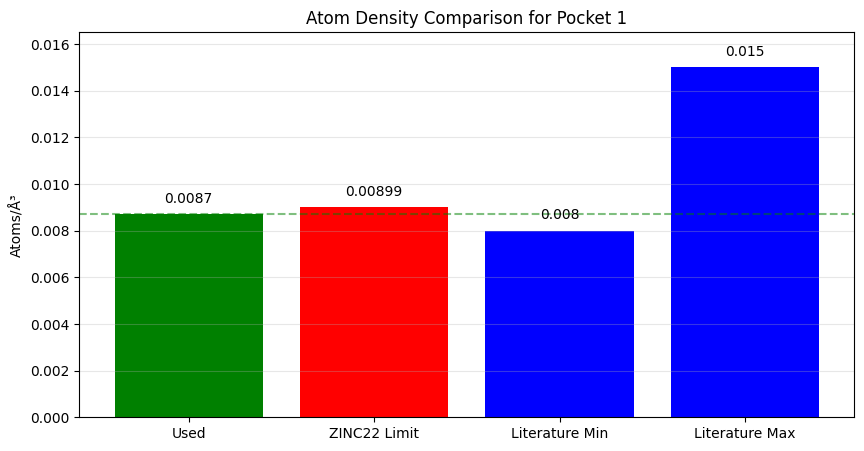

In [11]:
# Step 7: Final Pocket Summary with Empirical Scaling (LogP & Atom Count) 

print("Step 7: Final Pocket Summary")  # Print header for the final pocket summary section

# Ensure final_pocket was selected
if final_pocket is not None:  # Check if a final pocket was selected in earlier steps
    final_pocket_id = final_pocket.get("id")  # Get the pocket ID
    pocket_file_path = os.path.join(pocket_dir, f"pocket{final_pocket_id}_atm.pdb")  # Build path to the pocket file

    hydrophobicity = volume_mc = volume_ch = None  # Initialize key descriptor values

    if os.path.exists(pocket_file_path):  # Check that the descriptor file exists
        with open(pocket_file_path, 'r') as file:  # Open the descriptor file
            for line in file:  # Read through each line
                if "Hydrophobicity Score" in line:  # If hydrophobicity score is mentioned
                    hydrophobicity = float(re.search(r":\s*([0-9.]+)", line).group(1))  # Extract the numeric value
                elif "Pocket volume (Monte Carlo)" in line:  # If Monte Carlo volume is found
                    volume_mc = float(re.search(r":\s*([0-9.]+)", line).group(1))  # Extract the value
                elif "Pocket volume (convex hull)" in line:  # If convex hull volume is found
                    volume_ch = float(re.search(r":\s*([0-9.]+)", line).group(1))  # Extract the value

        if hydrophobicity is not None and volume_mc is not None:  # Ensure key values were found
            logp_estimate = round(hydrophobicity / 4.0, 2)  # Estimate LogP using empirical scaling
            heavy_atom_density = 0.0087  # Use literature-based atom density
            heavy_atom_estimate = round(volume_mc * heavy_atom_density, 1)  # Estimate heavy atom count
            max_density = 49 / volume_mc  # Max allowed density assuming 49 atoms is ZINC22 upper limit
            safety_margin = round((max_density - heavy_atom_density) / max_density * 100, 1)  # % below density limit

            print("Final Pocket Descriptor Summary")  # Output heading
            print(f"Pocket ID                        : {final_pocket_id}")  # Show ID
            print(f"Hydrophobicity Score             : {round(hydrophobicity, 2)}")  # Show hydrophobicity
            print(f"Pocket Volume (Monte Carlo)     : {round(volume_mc, 1)} Å³")  # Show MC volume
            print(f"Pocket Volume (Convex Hull)     : {round(volume_ch, 1)} Å³")  # Show convex hull volume
            print(f"LogP Estimate                    : {logp_estimate}")  # Show LogP
            print(f"Heavy Atom Estimate              : {heavy_atom_estimate}")  # Show atom count

            print("Validation Metrics:")  # Output validation header
            print(f"- Max density for ZINC22           : {round(max_density, 5)} atoms/Å³")  # Max density allowed
            print(f"- Safety margin                    : {safety_margin}% below limit")  # How safe the estimate is
            print("- Literature density range         : 0.008–0.015 atoms/Å³")  # Expected density range

            pocket_summary = {  # Store all key results in a dictionary
                "final_pocket_id": final_pocket_id,
                "volume_mc": volume_mc,
                "volume_ch": volume_ch,
                "hydrophobicity_score": hydrophobicity,
                "logp_estimate": logp_estimate,
                "heavy_atom_estimate": heavy_atom_estimate,
                "max_density": max_density,
                "safety_margin": safety_margin
            }

            # Load original centroid from Step 2 and merge it in
            centroid_path = os.path.join(base_dir, "selected_pocket_summary.json")  # Path to old summary file
            if os.path.exists(centroid_path):  # If it exists
                with open(centroid_path, "r") as cf:  # Load the previous file
                    old_data = json.load(cf)  # Read contents as JSON
                    if "centroid" in old_data:  # If centroid is present
                        pocket_summary["centroid"] = old_data["centroid"]  # Add it to new summary

            # Save full updated summary
            with open(os.path.join(base_dir, "selected_pocket_summary.json"), "w") as f:  # Open file for writing
                json.dump(pocket_summary, f, indent=4)  # Save summary as formatted JSON

            # Plot density comparison
            densities = {  # Dictionary of density values for plotting
                'Used': heavy_atom_density,
                'ZINC22 Limit': max_density,
                'Literature Min': 0.008,
                'Literature Max': 0.015
            }

            plt.figure(figsize=(10, 5))  # Create a wide figure
            colors = ['green', 'red', 'blue', 'blue']  # Bar colors
            plt.bar(densities.keys(), densities.values(), color=colors)  # Create bar chart
            plt.axhline(y=heavy_atom_density, color='green', linestyle='--', alpha=0.5)  # Reference line
            plt.title(f'Atom Density Comparison for Pocket {final_pocket_id}')  # Chart title
            plt.ylabel('Atoms/Å³')  # Y-axis label
            plt.ylim(0, max(densities.values()) * 1.1)  # Add padding above highest bar

            for i, v in enumerate(densities.values()):  # Add value labels above bars
                plt.text(i, v + 0.0005, str(round(v, 5)), ha='center')

            plt.grid(axis='y', alpha=0.3)  # Light gridlines on Y axis
            plot_path = os.path.join(pocket_dir, f"pocket{final_pocket_id}_density_plot.png")  # Output plot path
            plt.savefig(plot_path)  # Save figure to disk
            print(f"Saved density comparison plot to: {plot_path}")  # Confirm save

            print("Notes:")  # Additional context notes
            print("- LogP ≈ Hydrophobicity / 4.0 (empirical scale for drug-likeness)")  # LogP rule
            print("- Atom count scaled to stay within ZINC22 max of 49 atoms")  # Atom cap rule
            print("- Monte Carlo volume = biologically accessible pocket size")  # MC volume interpretation

        else:
            print("Missing volume or hydrophobicity values in pocket descriptor.")  # Error if values not found
    else:
        print(f"Pocket descriptor not found at: {pocket_file_path}")  # Error if file doesn't exist
else:
    print("No pocket selected in Step 2.")  # Error if final_pocket is missing


Step 8: Compound Folder Setup & ZINC22 Filtering Guidance

In [12]:
# Step 8: Compound Folder Setup & ZINC22 Filtering Guidance 
import os  # Import the OS module to handle file paths and directories

# Reminder for users 
print("Ensure Step 7 has been executed before running Step 8.")  # Warn user that Step 7 must be completed
print("This step uses pocket descriptors from Step 7 for filtering guidance.")  # Clarify what Step 8 depends on

# Validate pocket_summary from Step 7 
if 'pocket_summary' in globals():  # Check if pocket_summary was created in Step 7
    hydrophobicity = pocket_summary.get('hydrophobicity_score', 'N/A')  # Get hydrophobicity score
    volume_mc = pocket_summary.get('volume_mc', 'N/A')  # Get Monte Carlo pocket volume
    volume_ch = pocket_summary.get('volume_ch', 'N/A')  # Get convex hull pocket volume
    logp_estimate = pocket_summary.get('logp_estimate', 'N/A')  # Get LogP estimate
    heavy_atom_estimate = pocket_summary.get('heavy_atom_estimate', 'N/A')  # Get heavy atom estimate
    safety_margin = pocket_summary.get('safety_margin', 'N/A')  # Get safety margin
else:
    print("Error: `pocket_summary` not found. Please complete Step 7 before continuing.")  # Error message
    raise RuntimeError("Missing `pocket_summary` from Step 7.")  # Stop execution if summary is missing

# Display Step 7 pocket summary 
print("Based on your selected pocket properties:")  # Introduce the summary to the user
print(f"• Hydrophobicity: {round(hydrophobicity, 2)}")  # Show hydrophobicity score
print(f"• Pocket Volume (Monte Carlo): {round(volume_mc, 1)} Å³")  # Show MC volume
print(f"• Pocket Volume (Convex Hull): {round(volume_ch, 1)} Å³")  # Show convex hull volume
print(f"• LogP Estimate: {logp_estimate}   (scaled hydrophobicity ÷ 4.0)")  # Explain LogP estimate
print(f"• Heavy Atom Estimate (Monte Carlo): {heavy_atom_estimate}   (volume × 0.0087)")  # Explain atom estimate
print(f"• Safety Margin: {safety_margin}% below threshold")  # Show safety margin

# Compound folder setup 
print("Step 8: ZINC22 Compound Filtering Guidance")  # Step 8 header

# Define both folder paths
zinc_folder = os.path.join(base_dir, "zinc_compounds")  # Set path for ZINC22 compounds
pubchem_folder = os.path.join(base_dir, "pubchem_compounds")  # Set path for PubChem compounds

# Create compound folders if needed
for folder in [zinc_folder, pubchem_folder]:  # Loop through both folders
    if not os.path.exists(folder):  # If folder doesn't exist
        os.makedirs(folder)  # Create it
        print(f"Folder created at: {folder}")  # Confirm creation
    else:
        print(f"Folder already exists: {folder}")  # Confirm existence

# Provide Tranche UI link and filtering suggestions 
print("Use these values to guide your filter on ZINC22:")  # Prompt for user to apply filters
print("https://cartblanche22.docking.org/tranches/3d")  # Link to ZINC22 filter UI

# Estimate ZINC22 tranche P-range based on LogP
try:
    logp_floor = int(float(logp_estimate) // 1 * 100)  # Round down LogP and convert to P-range value
    logp_range = f"P{logp_floor} – P700"  # Define range up to P700
except:
    logp_range = "P??? – P700"  # Handle error if LogP estimate is not a number

# Display guidance
print("Suggested Tranche Filters:")  # Introduce suggested filters
print(f"• LogP (P-range)       : {logp_range}")  # Display suggested LogP range
try:
    print(f"• Heavy Atom Count     : H{int(heavy_atom_estimate)} ± 2")  # Show atom count range
except:
    print("• Heavy Atom Count     : H?? ± 2")  # Handle error if atom count is missing
print("• Layer                : big-leads or leads")  # Recommend layer filter

# Provide instructions for ZINC22 compound download 
print("Place Your .curl File (from ZINC22)")  # Instruct user to place curl file
print("After selecting filters, download the .curl file and place it here:")  # Instructions for saving
print(f"{zinc_folder}")  # Show target folder path

# PubChem fallback instructions with clearer file guidance 
print("If ZINC22 is unavailable:")  # Alert about fallback
print("Visit: https://pubchem.ncbi.nlm.nih.gov/")  # Provide PubChem URL
print("Search for: 'approved drugs' or 'antibiotics'")  # Suggest search terms
print("Format: SDF | Choose '3D Conformers'")  # File format guidance
print("Save the file as: PubChem_compound_text_approved_drugs_records.sdf")  # Naming convention
print("And place it in this folder (located inside your base directory))pubchem")  # Show folder

# Ask user which source to use 
print("Compound Source Selection")  # Prompt for source selection
while True:  # Keep asking until valid input
    source_choice = input("Do you want to use compounds from ZINC22 or PubChem? (zinc/pubchem): ").strip().lower()  # Ask user
    if source_choice in ['zinc', 'pubchem']:  # Acceptable answers
        break  # Exit loop
    print("Invalid input. Please enter 'zinc' or 'pubchem'.")  # Handle invalid input

# Set flags based on user choice
use_zinc = source_choice == 'zinc'  # True if ZINC was chosen
use_pubchem = not use_zinc  # True if PubChem was chosen

compound_folder = zinc_folder if use_zinc else pubchem_folder  # Set working folder
print(f"Using folder: {compound_folder}")  # Confirm folder path
os.makedirs(compound_folder, exist_ok=True)  # Make sure folder exists

# If using PubChem, give a reminder
if use_pubchem:  # If user chose PubChem
    print("You selected PubChem.")  # Confirm selection
    print("Please skip Steps 9–11 and go directly to Step 12 to load your PubChem `.sdf` file.")  # Forward instructions


Ensure Step 7 has been executed before running Step 8.
This step uses pocket descriptors from Step 7 for filtering guidance.
Based on your selected pocket properties:
• Hydrophobicity: 19.05
• Pocket Volume (Monte Carlo): 5448.0 Å³
• Pocket Volume (Convex Hull): 14819.5 Å³
• LogP Estimate: 4.76   (scaled hydrophobicity ÷ 4.0)
• Heavy Atom Estimate (Monte Carlo): 47.4   (volume × 0.0087)
• Safety Margin: 3.3% below threshold
Step 8: ZINC22 Compound Filtering Guidance
Folder already exists: /home/lucianghiba/MSc_Project/zinc_compounds
Folder already exists: /home/lucianghiba/MSc_Project/pubchem_compounds
Use these values to guide your filter on ZINC22:
https://cartblanche22.docking.org/tranches/3d
Suggested Tranche Filters:
• LogP (P-range)       : P400 – P700
• Heavy Atom Count     : H47 ± 2
• Layer                : big-leads or leads
Place Your .curl File (from ZINC22)
After selecting filters, download the .curl file and place it here:
/home/lucianghiba/MSc_Project/zinc_compounds
If ZI

Do you want to use compounds from ZINC22 or PubChem? (zinc/pubchem):  pubchem


Using folder: /home/lucianghiba/MSc_Project/pubchem_compounds
You selected PubChem.
Please skip Steps 9–11 and go directly to Step 12 to load your PubChem `.sdf` file.


Step 9: Identify .curl File and Extract URLs

In [ ]:
# Step 9: Identify .curl File and Download .tgz
import os
import glob
import requests

# This step reads a ZINC22 .curl file containing a .tgz URL for 3D ligand structures.
# It downloads the .tgz into zinc_compounds/ for extraction in Step 10.

# Folder containing ZINC curl files
curl_folder = "zinc_compounds"

# Auto-detect any .curl file in the folder
curl_files = glob.glob(os.path.join(curl_folder, "*.curl"))

if not curl_files:
    raise FileNotFoundError("❌ No .curl files found in zinc_compounds/. Please download one from files2.docking.org.")

# Use the first .curl file found
curl_path = curl_files[0]
print(f"📄 Using .curl file: {os.path.basename(curl_path)}")

# Read the .curl file and extract the actual URL from the line
with open(curl_path, "r") as f:
    curl_line = f.read().strip()

# Extract the URL from the curl command (assumes last word is the URL)
url = curl_line.split()[-1]
print(f"🌐 Extracted download URL: {url}")

# Extract filename from URL
tgz_filename = os.path.basename(url)
tgz_save_path = os.path.join(curl_folder, tgz_filename)

# Download the file
response = requests.get(url)
if response.status_code == 200:
    with open(tgz_save_path, "wb") as f_out:
        f_out.write(response.content)
    print(f"✅ .tgz file downloaded to: {tgz_save_path}")
else:
    raise Exception(f"❌ Failed to download .tgz file. Status code: {response.status_code}")



Step 10: Extract downloaded URLs (ZINC22 only)

In [ ]:
# Step 10: Extract downloaded URLs (ZINC22 only)
import tarfile

# Reuse the downloaded tgz file path from Step 9
# (You can reassign this if running Step 10 independently)
tgz_path = tgz_save_path  # Make sure tgz_save_path is still available from Step 9

# Create a folder to extract into
extracted_folder = os.path.join(curl_folder, "extracted_sdfs")
os.makedirs(extracted_folder, exist_ok=True)

# Extract contents
with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall(path=extracted_folder, filter="data")  # Secure extraction

print(f"✅ Extracted contents to: {extracted_folder}")

# Optional: List extracted files
extracted_files = os.listdir(extracted_folder)
print("📦 Extracted files:")
for file in extracted_files:
    print(f" - {file}")


Step 12: Extract .tgz files OR use Pubchem SDFs

In [13]:
# === Step 12: Extract .tgz Files or Use PubChem SDFs ===

# Define a function to extract .sdf files from .tgz archives downloaded from ZINC22
def extract_tgz_flat(zinc_folder, output_folder):
    print("\n--- Step 12: Extract ZINC .tgz Files ---")  # Announce start of Step 12

    # Inform the user why this step is important for their filtering pipeline
    print("Why this matters:")
    print("- ZINC compound libraries are often distributed in compressed .tgz format.")  # ZINC files are compressed
    print("- These contain SDF (Structure Data File) files with 3D molecular information.")  # They include structure data
    print("- Extracting them allows you to process the molecules with RDKit and other tools.")  # Needed for RDKit analysis

    # Check if output folder exists and already contains .sdf files
    if os.path.exists(output_folder):  # If the output folder exists
        sdf_files = [f for f in os.listdir(output_folder) if f.endswith(".sdf")]  # List any existing SDFs
        if sdf_files:  # If there are SDFs already extracted
            print(f"Existing extracted SDF files found in: {output_folder}")  # Notify user
            print("Skipping extraction to save time.")  # Skip extraction
            return  # Exit function
        else:
            print(f"Folder exists but contains no .sdf files: {output_folder}")  # Folder is empty, continue below
    else:
        os.makedirs(output_folder, exist_ok=True)  # Create output folder if it doesn’t exist

    # Ask user for permission to begin extraction
    print("No extracted SDF files detected.")  # Notify user
    proceed = input("Would you like to extract the .tgz files now? (yes/no): ").strip().lower()  # Prompt input
    if proceed != "yes":  # If user declines
        print("Extraction skipped. Make sure to extract manually before continuing.")  # Exit with message
        return

    # Begin extraction process
    print(f"Looking for .tgz files in: {zinc_folder}")  # Show source folder
    extracted = 0  # Counter to track number of files extracted
    for fname in os.listdir(zinc_folder):  # Loop through files in ZINC folder
        if fname.endswith(".tgz"):  # Only process .tgz files
            fpath = os.path.join(zinc_folder, fname)  # Full path to the .tgz file
            try:
                with tarfile.open(fpath, "r:gz") as tar:  # Open the tar.gz file
                    sdf_members = [m for m in tar.getmembers() if m.name.endswith(".sdf")]  # Filter for SDFs
                    for member in sdf_members:  # For each .sdf file inside archive
                        member.name = os.path.basename(member.name)  # Remove subfolder paths inside archive
                        tar.extract(member, path=output_folder)  # Extract SDF file into output folder
                print(f"Extracted from {fname}")  # Confirm extraction
                extracted += 1  # Increment counter
            except Exception as e:  # If any extraction error occurs
                print(f"Failed: {fname} — {e}")  # Print error message
    
    # Final report
    if extracted == 0:  # No files were extracted
        print("No .tgz files were extracted.")
    else:
        print(f"Done. SDF files are now available in: {output_folder}")  # Success message

# === Run Step 12 Based on Compound Source ===

# If user selected ZINC22 as the compound source
if use_zinc:
    extracted_folder = os.path.join(zinc_folder, "extracted_sdfs")  # Define output folder path
    extract_tgz_flat(zinc_folder, extracted_folder)  # Call extraction function

# If user selected PubChem instead of ZINC
elif use_pubchem:
    print("Step 12: PubChem Compound SDF")  # Announce PubChem workflow
    print("You selected PubChem.")  # Confirm selection
    print("Please ensure your PubChem SDF file is already saved in the folder:")  # Reminder to save file
    print(f"   {pubchem_folder}")  # Show target folder
    
    sdf_files = [f for f in os.listdir(pubchem_folder) if f.endswith(".sdf")]  # Search for SDF files
    if sdf_files:  # If files are found
        print(f"Found {len(sdf_files)} SDF file(s):")  # Report number of files
        for f in sdf_files:
            print(f"• {f}")  # List each file
    else:
        print("No .sdf files found in the folder.")  # Warn if none found
        print("Please download and save a 3D SDF file from PubChem before continuing.")  # Next action for user


Step 12: PubChem Compound SDF
You selected PubChem.
Please ensure your PubChem SDF file is already saved in the folder:
   /home/lucianghiba/MSc_Project/pubchem_compounds
Found 1 SDF file(s):
• PubChem_bioassay_text_lipinski_records.sdf


Step 13: Filter Ligands by RDKit Properties (logP & Heavy Atom Count)

 Step 13: Filter Ligands by RDKit LogP and Heavy Atom Count ---
Why are we filtering?
- LogP (octanol–water partition coefficient) estimates how hydrophobic a molecule is.
- Heavy atom count tells us about molecular size and complexity.
- Filtering removes molecules that are too greasy, too large, or too small to be useful drugs.
- This improves the quality of candidates for docking and reduces wasted computation time later.



Do you want to apply LogP/Heavy Atom filtering now? (yes/no):  yes


Recommended filtering ranges:
   • LogP: 0.0 – 7.0 (drug-like range)
   • Heavy Atom Count: 5 – 60 (reasonable molecular size)



Enter minimum LogP [default 0.0]:  1
Enter maximum LogP [default 7.0]:  5
Enter minimum Heavy Atom Count [default 5]:  8
Enter maximum Heavy Atom Count [default 60]:  40


Filtering ligands... Please wait.

Total .sdf files found: 1


Processing SDF files:   0%|          | 0/1 [00:00<?, ?file/s]

Done filtering molecules.
Total kept: 1749 | Skipped: 0



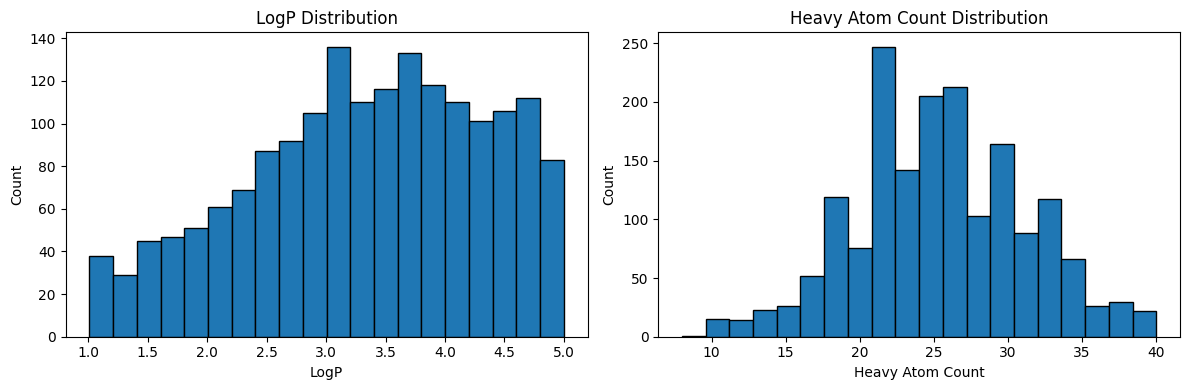

Do you want to work with a subset of the filtered ligands? (yes/no):  no


Saving ligands to file... this may take a few moments...
Saved 1749 ligands to: /home/lucianghiba/MSc_Project/pubchem_filtered/filtered_ligands.sdf
Time taken: 5.93 seconds


Ready to proceed with 1749 ligands? (yes to continue):  yes


In [14]:
# Step 13: Filter Ligands by RDKit LogP and Heavy Atom Count

# Disable RDKit warnings to keep output clean
RDLogger.DisableLog('rdApp.*')

# Print step header
print(" Step 13: Filter Ligands by RDKit LogP and Heavy Atom Count ---")

# Educational context
print("Why are we filtering?")
print("- LogP (octanol–water partition coefficient) estimates how hydrophobic a molecule is.")
print("- Heavy atom count tells us about molecular size and complexity.")
print("- Filtering removes molecules that are too greasy, too large, or too small to be useful drugs.")
print("- This improves the quality of candidates for docking and reduces wasted computation time later.\n")

# Set correct input/output paths based on selected compound source
if use_zinc:
    # Set input and output folders for ZINC compounds
    extracted_folder = os.path.join(base_dir, "zinc_compounds", "sdf_extracted")
    filtered_folder = os.path.join(base_dir, "zinc_compounds", "zinc_filtered")
elif use_pubchem:
    # Set input and output folders for PubChem compounds
    extracted_folder = os.path.join(base_dir, "pubchem_compounds")
    filtered_folder = os.path.join(base_dir, "pubchem_filtered")
else:
    # If neither compound source is selected, raise an error
    raise ValueError("No compound source selected. Please run Step 8 first.")

# Create the filtered folder if it doesn’t exist
os.makedirs(filtered_folder, exist_ok=True)

# === Ask user whether to filter ligands ===
# Ask user if they want to proceed with filtering based on descriptors
perform_filtering = input("Do you want to apply LogP/Heavy Atom filtering now? (yes/no): ").strip().lower()
filtered_ligands = []  # Initialize empty list to store filtered molecules

if perform_filtering == "yes":
    # === Prompt for filtering thresholds ===
    # Print suggested filter ranges
    print("Recommended filtering ranges:")
    print("   • LogP: 0.0 – 7.0 (drug-like range)")
    print("   • Heavy Atom Count: 5 – 60 (reasonable molecular size)\n")

    try:
        # Ask user to input min and max LogP and heavy atom counts
        logp_min = float(input("Enter minimum LogP [default 0.0]: ") or 0.0)
        logp_max = float(input("Enter maximum LogP [default 7.0]: ") or 7.0)
        ha_min = int(input("Enter minimum Heavy Atom Count [default 5]: ") or 5)
        ha_max = int(input("Enter maximum Heavy Atom Count [default 60]: ") or 60)
    except ValueError:
        # If invalid input is provided, fall back to defaults
        print("Invalid input. Using defaults.")
        logp_min, logp_max, ha_min, ha_max = 0.0, 7.0, 5, 60

    # Begin filtering timer
    print("Filtering ligands... Please wait.\n")
    start_time = time.time()
    total_mols, skipped_mols = 0, 0  # Counters for stats
    matching_mols = []  # Store molecules that match filter

    # === Gather all SDF paths from extracted folder ===
    sdf_paths = []
    for root, _, files in os.walk(extracted_folder):
        for f in files:
            if f.endswith(".sdf"):
                sdf_paths.append(os.path.join(root, f))

    print(f"Total .sdf files found: {len(sdf_paths)}")

    # === Filter molecules by LogP and Heavy Atom Count ===
    for sdf_path in tqdm(sdf_paths, desc="Processing SDF files", unit="file"):
        try:
            # Load molecules from file
            suppl = Chem.SDMolSupplier(sdf_path, sanitize=True)
            for mol in suppl:
                if mol is None:
                    skipped_mols += 1
                    continue
                try:
                    # Compute LogP and heavy atom count
                    logp = Descriptors.MolLogP(mol)
                    ha = Descriptors.HeavyAtomCount(mol)
                    total_mols += 1
                    # Keep molecule if it falls within the user-defined range
                    if logp_min <= logp <= logp_max and ha_min <= ha <= ha_max:
                        matching_mols.append(mol)
                except:
                    skipped_mols += 1
                    continue
        except:
            skipped_mols += 1
            continue

    # Print final filter results
    print("Done filtering molecules.")
    print(f"Total kept: {len(matching_mols)} | Skipped: {skipped_mols}\n")

    # === Visualise descriptor distributions ===
    if matching_mols:
        # Compute descriptors for kept molecules
        logp_values = [Descriptors.MolLogP(mol) for mol in matching_mols]
        ha_values = [Descriptors.HeavyAtomCount(mol) for mol in matching_mols]

        # Plot LogP and heavy atom distributions
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        axs[0].hist(logp_values, bins=20, edgecolor='black')
        axs[0].set_title("LogP Distribution")
        axs[0].set_xlabel("LogP")
        axs[0].set_ylabel("Count")

        axs[1].hist(ha_values, bins=20, edgecolor='black')
        axs[1].set_title("Heavy Atom Count Distribution")
        axs[1].set_xlabel("Heavy Atom Count")
        axs[1].set_ylabel("Count")

        plt.tight_layout()
        plt.show()

    # === Ask user if they want to work with a subset ===
    subset_mode = input("Do you want to work with a subset of the filtered ligands? (yes/no): ").strip().lower()
    if subset_mode == "yes":
        while True:
            try:
                # Ask how many molecules to keep
                subset_size = int(input("Enter number of ligands to keep (e.g. 1000): "))
                if subset_size > len(matching_mols):
                    # Warn if requested size exceeds available molecules
                    print(f"Only {len(matching_mols)} ligands available. Try a smaller number or relax filters.")
                    retry = input("🔁 Retry with a different subset size or expand filter range? (yes/no): ").strip().lower()
                    if retry != "yes":
                        print("Subsetting cancelled. Proceeding with all available filtered ligands.")
                        filtered_ligands = matching_mols
                        break
                else:
                    # Use the first N molecules
                    filtered_ligands = matching_mols[:subset_size]
                    print(f"Using subset of {subset_size} ligands.")
                    break
            except ValueError:
                print("Invalid number. Please enter an integer.")
    else:
        filtered_ligands = matching_mols

    # === Save filtered ligands to disk ===
    print("Saving ligands to file... this may take a few moments...")
    output_path = os.path.join(filtered_folder, "filtered_ligands.sdf")
    writer = Chem.SDWriter(output_path)
    for mol in filtered_ligands:
        writer.write(mol)
    writer.close()

    # Report total time taken
    end_time = time.time()
    print(f"Saved {len(filtered_ligands)} ligands to: {output_path}")
    print(f"Time taken: {round(end_time - start_time, 2)} seconds")

else:
    # === Load ligands from previous filtering if user skips filtering ===
    print(f"Skipping filtering. Loading ligands from:\n{filtered_folder}\n")
    start_time = time.time()
    sdf_files = []

    # Find existing .sdf files
    for root, _, files in os.walk(filtered_folder):
        for file_name in files:
            if file_name.endswith(".sdf"):
                sdf_files.append(os.path.join(root, file_name))

    # Load molecules from filtered files
    for sdf_path in tqdm(sdf_files, desc="Loading filtered ligands"):
        mols = Chem.SDMolSupplier(sdf_path)
        filtered_ligands.extend([mol for mol in mols if mol is not None])

    end_time = time.time()
    print(f"Loaded {len(filtered_ligands)} ligands from {len(sdf_files)} file(s)")
    print(f"Time taken: {round(end_time - start_time, 2)} seconds")

# === Final confirmation before proceeding to next step ===
proceed = input(f"Ready to proceed with {len(filtered_ligands)} ligands? (yes to continue): ").strip().lower()
if proceed != "yes":
    print("Pipeline paused. You may restart or adjust your filters.")
    exit()




🧪 Displaying First 10 RDKit-validated Ligands:



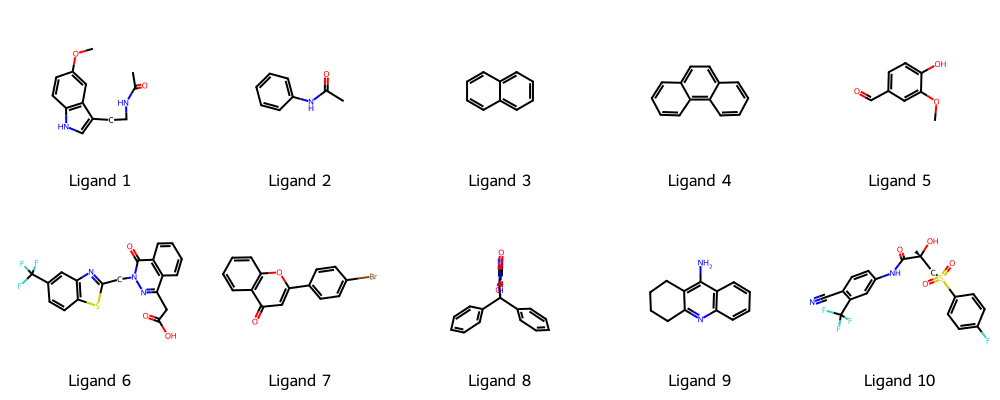

In [15]:
# Print a header to indicate we are about to display ligands
print("\n🧪 Displaying First 10 RDKit-validated Ligands:\n")

# Create a list of the first 10 non-None ligand molecules for visualization
mol_images = [mol for mol in filtered_ligands[:10] if mol is not None]

# Check if any valid molecules were found
if mol_images:
    # Generate a grid image of the selected molecules using RDKit
    img = Draw.MolsToGridImage(
        mol_images,                  # List of molecules to draw
        molsPerRow=5,                # Display 5 molecules per row
        subImgSize=(200, 200),       # Set size of each sub-image (in pixels)
        legends=[f"Ligand {i+1}" for i in range(len(mol_images))]  # Add legend below each molecule
    )
    
    # Display the generated image in the notebook (requires IPython.display or Jupyter)
    display(img)
else:
    # If no valid molecules were found, print a warning message
    print("⚠️ No valid ligands available for visualisation.")


Step 14: Ligand Volume Filtering + Preparation 

Step 14: Ligand Volume Filtering
Pocket volume loaded: 5448.0 Å³
Suggested ligand weight range: 272–389 Da


Filter ligands by weight (Da)? (yes/no):  yes
Enter min Da [default 272]:  272
Enter max Da [default 389]:  389


Processing ligands...



Ligand Prep:   0%|          | 0/1749 [00:00<?, ?it/s]


Prepared 938 ligands
Skipped 0 ligands
Output saved to: /home/lucianghiba/MSc_Project/prepared_ligands
Time taken: 132.77 sec
First 10 Ligands (Weight ~ Volume Estimate):
  Ligand 1: ~299.98 Da ≈ 5099.7 Å³
  Ligand 2: ~381.08 Da ≈ 6478.4 Å³
  Ligand 3: ~319.18 Da ≈ 5426.1 Å³
  Ligand 4: ~331.13 Da ≈ 5629.2 Å³
  Ligand 5: ~284.07 Da ≈ 4829.2 Å³
  Ligand 6: ~295.02 Da ≈ 5015.3 Å³
  Ligand 7: ~379.21 Da ≈ 6446.6 Å³
  Ligand 8: ~280.19 Da ≈ 4763.2 Å³
  Ligand 9: ~357.08 Da ≈ 6070.4 Å³
  Ligand 10: ~295.02 Da ≈ 5015.3 Å³


Show histogram of ligand weights? (yes/no):  yes


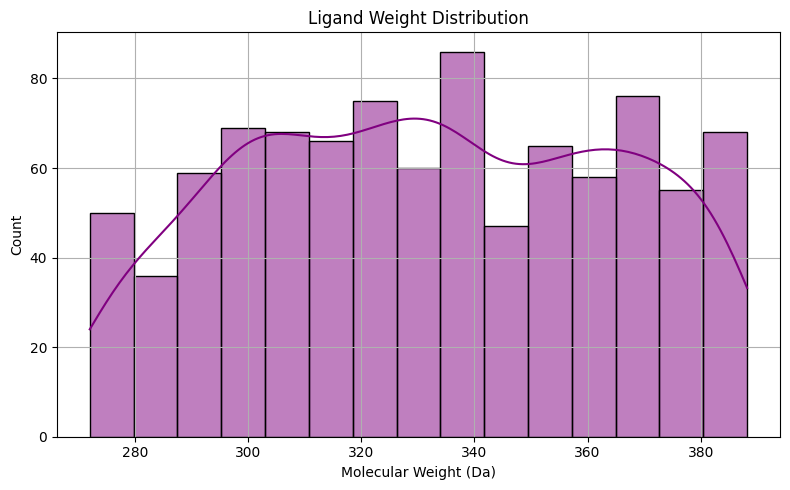

In [16]:
print("Step 14: Ligand Volume Filtering")

# === Define and create output directory ===
prep_folder = os.path.join(base_dir, "prepared_ligands")
os.makedirs(prep_folder, exist_ok=True)

# === Load pocket volume from previously saved JSON ===
try:
    with open(os.path.join(base_dir, "selected_pocket_summary.json"), "r") as f:
        pocket_summary = json.load(f)
    pocket_volume = pocket_summary.get("volume_mc", None)
except:
    pocket_volume = None

# === Estimate ligand weight range from pocket volume ===
if pocket_volume:
    default_min_volume = int(pocket_volume * 0.25)
    default_max_volume = int(pocket_volume * 1.25)
    approx_min_da = int(pocket_volume / 20)
    approx_max_da = int(pocket_volume / 14)
    print(f"Pocket volume loaded: {pocket_volume:.1f} Å³")
    print(f"Suggested ligand weight range: {approx_min_da}–{approx_max_da} Da")
else:
    approx_min_da, approx_max_da = 150, 500
    print("No pocket volume found. Using fallback range: 150–500 Da")

# === Ask user if filtering should be applied ===
do_filter = input("Filter ligands by weight (Da)? (yes/no): ").strip().lower()

if do_filter == "yes":
    try:
        vol_min = float(input(f"Enter min Da [default {approx_min_da}]: ") or approx_min_da)
        vol_max = float(input(f"Enter max Da [default {approx_max_da}]: ") or approx_max_da)
    except:
        print("Invalid input, using default range.")
        vol_min, vol_max = approx_min_da, approx_max_da
else:
    vol_min, vol_max = None, None

# === Begin ligand preparation ===
prepared_ligands = []
skipped = 0
start = time.time()
print("Processing ligands...\n")

# === Loop through filtered ligands ===
for i, mol in enumerate(tqdm(filtered_ligands, desc="Ligand Prep")):
    if mol is None:
        skipped += 1
        continue

    try:
        # Add hydrogens
        mol = Chem.AddHs(mol)

        # Generate 3D coordinates
        if AllChem.EmbedMolecule(mol, randomSeed=42) != 0:
            skipped += 1
            continue

        # Optimize geometry
        AllChem.UFFOptimizeMolecule(mol)

        # Calculate molecular weight
        mw = rdMolDescriptors.CalcExactMolWt(mol)

        # Apply weight filter if enabled
        if vol_min and vol_max and not (vol_min <= mw <= vol_max):
            continue

        # Save to list and .sdf
        prepared_ligands.append(mol)
        writer = Chem.SDWriter(os.path.join(prep_folder, f"ligand_{i+1}.sdf"))
        writer.write(mol)
        writer.close()

    except Exception as e:
        skipped += 1

# === Summary ===
end = time.time()
print(f"\nPrepared {len(prepared_ligands)} ligands")
print(f"Skipped {skipped} ligands")
print(f"Output saved to: {prep_folder}")
print(f"Time taken: {round(end - start, 2)} sec")

# === Show summary preview ===
if prepared_ligands:
    weights = [round(rdMolDescriptors.CalcExactMolWt(m), 2) for m in prepared_ligands[:10]]
    volumes_est = [round(w * 17.0, 1) for w in weights]  # Rough volume estimate

    print("First 10 Ligands (Weight ~ Volume Estimate):")
    for i, (w, v) in enumerate(zip(weights, volumes_est)):
        print(f"  Ligand {i+1}: ~{w} Da ≈ {v} Å³")

    # Ask if user wants histogram
    show_plot = input("Show histogram of ligand weights? (yes/no): ").strip().lower()
    if show_plot == "yes":
        all_weights = [rdMolDescriptors.CalcExactMolWt(m) for m in prepared_ligands]
        plt.figure(figsize=(8, 5))
        sns.histplot(all_weights, bins=15, kde=True, color="purple")
        plt.title("Ligand Weight Distribution")
        plt.xlabel("Molecular Weight (Da)")
        plt.ylabel("Count")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipped histogram.")
else:
    print("No ligands to preview.")



Step 15: Molecular Descriptor Matrix with ZINC + PubChem Support

In [17]:
# Step 15: Generating Molecular Descriptor Matrix               
print("Step 15: Generating Molecular Descriptor Matrix")           
print("This step creates a structured DataFrame of properties for each ligand to support ML or clustering.") 
print("Descriptors include: logP, MW, TPSA, H-bond donors/acceptors, rotatable bonds, and volume estimation.") 

# Van der Waals radii (Bondi 1964; used for estimating atomic volume)
vdw_radii = {                                                       # Dictionary mapping atom symbols to Bondi VdW radii (Å)
    'H': 1.20, 'C': 1.70, 'N': 1.55, 'O': 1.52, 'F': 1.47,          # Common atom radii values
    'P': 1.80, 'S': 1.80, 'Cl': 1.75, 'Br': 1.85, 'I': 1.98         # Additional heteroatom radii values
}

def estimate_volume_rdkit(mol):                                     # Fallback volume estimator if ElectroShape is unavailable
    """
    Estimate molecular volume by summing atomic van der Waals volumes. # Docstring describing the method
    Radii values are based on: A. Bondi, J. Phys. Chem., 1964, 68, 441–451. # Citation for radii source
    """
    volume = 0.0                   # Initialize volume accumulator
    for atom in mol.GetAtoms():         # Iterate over atoms in the molecule
        symbol = atom.GetSymbol()          # Get atomic symbol (e.g., 'C', 'N')
        r = vdw_radii.get(symbol, 1.5)         # Fetch radius; use 1.5 Å default if unknown
        volume += (4/3) * math.pi * (r ** 3)    # Add atomic VdW volume (sphere formula)
    return volume                                                   # Return total estimated volume

# Auto-select ligand source (ZINC or PubChem) ===
ligand_sources = [                 # Candidate folders containing SDF files
    os.path.join(base_dir, "zinc_compounds"),    # ZINC ligands directory
    os.path.join(base_dir, "pubchem_filtered")        # PubChem ligands directory
]

available_sdfs = []                          # Will hold tuples of (folder, filename, molecule_count)
for folder in ligand_sources:                      # Loop through potential source folders
    if os.path.exists(folder):                         # Check folder exists
        for fname in os.listdir(folder):                   # Iterate over files in the folder
            if fname.endswith(".sdf") and not fname.startswith("."):# Accept non‑hidden SDF files only
                full_path = os.path.join(folder, fname)             # Build absolute path to SDF
                mols = [m for m in Chem.SDMolSupplier(full_path) if m is not None]  # Load molecules, skip invalid
                if mols:                                            # Ensure file actually contained valid molecules
                    available_sdfs.append((folder, fname, len(mols)))# Store file info and ligand count

if not available_sdfs:                                              # No SDFs found → abort
    cprint("No valid SDF files found in either zinc_compounds/ or pubchem_filtered/!", "red")  # Error message
    exit()                                                          # Terminate script

# Prompt user to select ligand file 
print("Available ligand files for descriptor calculation:")         # List header
for i, (folder, fname, count) in enumerate(available_sdfs):         # Enumerate each available SDF
    print(f"  {i+1}. {fname} in {os.path.basename(folder)} ({count} ligands)")  # Print numbered choice with count

try:
    selection = int(input("Select file to use (enter number): ")) - 1  # Read user selection (1‑based → 0‑based index)
    sdf_folder, sdf_filename, _ = available_sdfs[selection]         # Unpack chosen tuple
    input_file = os.path.join(sdf_folder, sdf_filename)             # Full path of selected SDF
except (IndexError, ValueError):                                    # Handle out‑of‑range or non‑integer input
    cprint("Invalid selection. Exiting.", "red")                    # Error message
    exit()                                                          # Terminate script

# Try ElectroShape import
try:
    from electroshape import ElectroShape  # Attempt to import ElectroShape library
    es_available = True                 # Flag ElectroShape availability
    es = ElectroShape()              # Instantiate ElectroShape calculator
    volume_col_name = "Volume"     # Column header when ElectroShape is used
except ImportError:
    cprint("ElectroShape not available. Falling back to atomic volume estimation (Bondi 1964).", "yellow") # Warning
    es_available = False                          # Mark ElectroShape not available
    volume_col_name = "EstimatedVolume"      # Alternate column header for fallback

# Process Ligands 
suppl = Chem.SDMolSupplier(input_file)           # Create RDKit supplier to stream ligands
data = []                   # List to collect descriptor dictionaries

TEST_LIMIT = None  # Set a number for testing (e.g., 10)         # Optional ligand count limiter during dev/debug

print("Generating descriptors for ligands...")           # Progress message
for i, mol in enumerate(suppl):                        # Iterate over ligands with index
    if mol:                               # Skip invalid mol objects (None)
        try:
            mol_id = mol.GetProp("_Name") if mol.HasProp("_Name") else f"Ligand_{i+1}"  # Use title or fallback ID

            # Compute descriptors
            logP = Crippen.MolLogP(mol)                             # ClogP (partition coefficient)
            mw = Descriptors.MolWt(mol)                             # Molecular weight
            tpsa = rdMolDescriptors.CalcTPSA(mol)                   # Topological polar surface area
            hbd = Lipinski.NumHDonors(mol)                          # Number of H‑bond donors
            hba = Lipinski.NumHAcceptors(mol)                       # Number of H‑bond acceptors
            rot_bonds = Lipinski.NumRotatableBonds(mol)             # Rotatable bond count

            # Compute volume
            if es_available:                                        # Prefer ElectroShape if present
                try:
                    volume = es.calculate_volume(mol)               # Get ElectroShape volume
                except Exception as ve:                             # Handle ElectroShape failures
                    print(f"ElectroShape volume failed for {mol_id}: {ve}") # Log error
                    volume = None                                   # Set volume to None for this ligand
            else:
                volume = estimate_volume_rdkit(mol)                 # Fallback to Bondi VdW volume estimation

            data.append({         # Append descriptor dict for DataFrame row
                "Ligand_ID": mol_id,  # Ligand identifier
                "logP": logP,        # logP descriptor
                "MW": mw,     # Molecular weight
                "TPSA": tpsa,           # Polar surface area
                "HBD": hbd,             # Hydrogen‑bond donors
                "HBA": hba,                # Hydrogen‑bond acceptors
                "RotatableBonds": rot_bonds,     # Rotatable bonds
                volume_col_name: volume     # Calculated volume (method‑dependent)
            })

        except Exception as e:                                      # Catch descriptor failures
            print(f"Ligand {i+1} failed: {e}")                      # Log error to console

        if TEST_LIMIT and i + 1 >= TEST_LIMIT:                      # Break early if test limit reached
            break                                                   # Exit ligand loop

# Build and Save Descriptor Matrix 
df = pd.DataFrame(data).dropna(subset=["logP", "MW", "TPSA"])       # Create DataFrame & drop rows missing key cols
descriptor_file = os.path.join(sdf_folder, "ligand_descriptor_matrix.csv")  # Output CSV path
df.to_csv(descriptor_file, index=False)                             # Write descriptors to CSV (no index)

cprint(f"Descriptor matrix saved to: {descriptor_file}", "green")   # Confirmation message in green

# Preview the DataFrame 
pd.set_option("display.max_columns", None)                          # Show all columns in notebook preview
pd.set_option("display.max_rows", 10)                               # Limit displayed rows to 10
display(df.head(10))                                                # Display the first 10 ligand rows


Step 15: Generating Molecular Descriptor Matrix
This step creates a structured DataFrame of properties for each ligand to support ML or clustering.
Descriptors include: logP, MW, TPSA, H-bond donors/acceptors, rotatable bonds, and volume estimation.
Available ligand files for descriptor calculation:
  1. filtered_ligands.sdf in pubchem_filtered (1749 ligands)


Select file to use (enter number):  1


ElectroShape not available. Falling back to atomic volume estimation (Bondi 1964).
Generating descriptors for ligands...
Descriptor matrix saved to: /home/lucianghiba/MSc_Project/pubchem_filtered/ligand_descriptor_matrix.csv


,Ligand_ID,logP,MW,TPSA,HBD,HBA,RotatableBonds,EstimatedVolume
0,896,1.85510,232.283,54.12,2,2,4,328.151358
1,904,1.64500,135.166,29.10,1,1,1,194.944968
2,931,2.83980,128.174,0.00,0,0,0,205.795263
3,995,3.99300,178.234,0.00,0,0,0,288.113368
4,1183,1.21330,152.149,46.53,1,3,2,208.766891
5,1613,3.70040,419.384,85.08,1,6,4,546.283663
6,1686,4.22250,301.139,30.21,0,2,1,364.635197
7,1775,1.76960,252.273,58.20,2,2,2,369.310410
8,1935,2.69580,198.269,38.91,1,2,0,298.730904
9,2375,2.87958,430.379,107.26,2,5,5,538.121621


Step 16 – Ligand Prioritization via Unsupervised Clustering (e.g. KMeans)

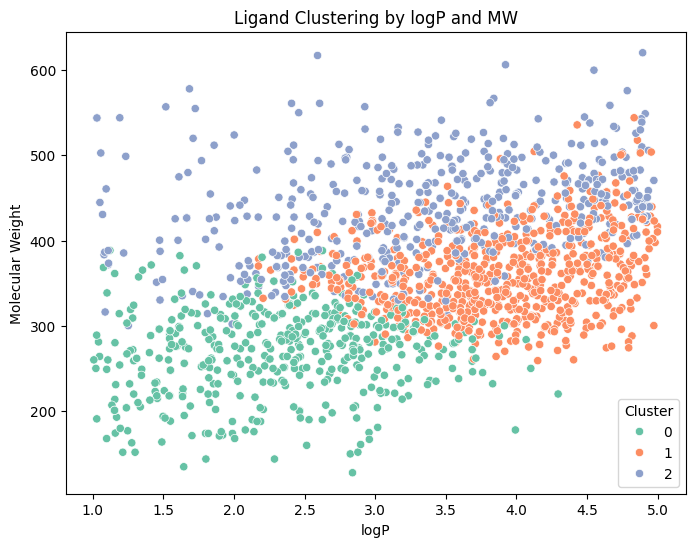

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the descriptor matrix
descriptor_file = "pubchem_filtered/ligand_descriptor_matrix.csv"
df = pd.read_csv(descriptor_file)

# Extract features (exclude Ligand_ID)
features = df.drop(columns=["Ligand_ID"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Run KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df["Cluster"] = clusters

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="logP", y="MW", hue="Cluster", palette="Set2")
plt.title("Ligand Clustering by logP and MW")
plt.xlabel("logP")
plt.ylabel("Molecular Weight")
plt.show()

# Save updated descriptor file
df.to_csv("pubchem_filtered/clustered_ligands.csv", index=False)


Step 20:  Drug-Likeness Radar Chart & Ranking Code


🧪 Top Ligands by Cluster (based on Drug-Likeness Score):

Cluster 0:
   Ligand_ID  DrugLikenessScore
0        896                  6
1        904                  6
2        931                  6

Cluster 1:
    Ligand_ID  DrugLikenessScore
5        1613                  6
6        1686                  6
12       2662                  6

Cluster 2:
    Ligand_ID  DrugLikenessScore
9        2375                  6
26       4485                  6
31       4735                  6



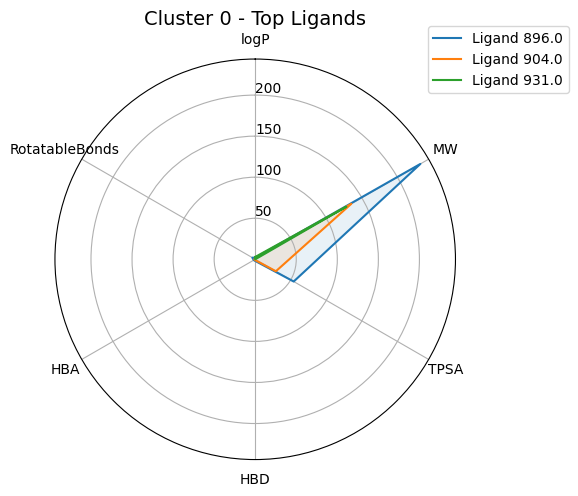

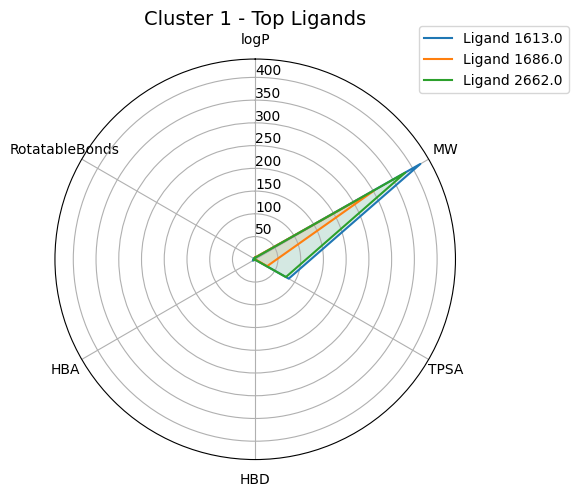

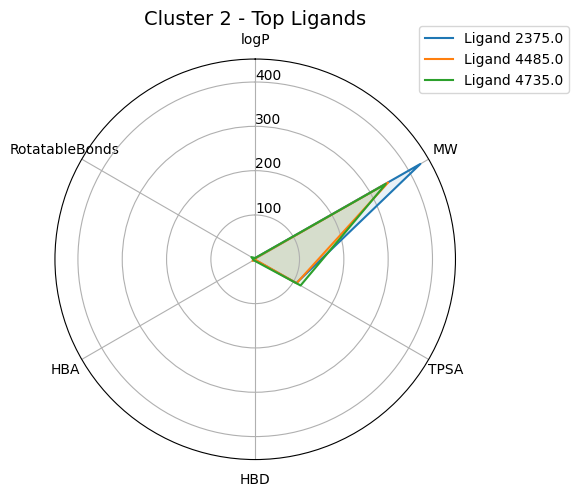

In [19]:
import pandas as pd       # Data analysis & manipulation library
import matplotlib.pyplot as plt   # Plotting library for visualizations
import numpy as np    # Numerical computing library (arrays, math)

# Step 1: Load clustered ligands
df = pd.read_csv("pubchem_filtered/clustered_ligands.csv")  # Read in CSV containing ligand descriptors + cluster labels

# Step 2: Define a simple drug‑likeness score (can expand later)
def drug_likeness_score(row):   # Function to assign score per ligand row
    score = 0    # Initialize score counter
    if row['logP'] <= 5: score += 1    # Lipinski: logP ≤ 5
    if row['MW'] <= 500: score += 1     # Lipinski: MW ≤ 500 Da
    if row['TPSA'] <= 140: score += 1   # Polar surface area ≤ 140 Å²
    if row['HBD'] <= 5: score += 1     # H‑bond donors ≤ 5
    if row['HBA'] <= 10: score += 1    # H‑bond acceptors ≤ 10
    if row['RotatableBonds'] <= 10: score += 1   # Rotatable bonds ≤ 10
    return score        # Return cumulative score (0‑6)

# Apply score
df['DrugLikenessScore'] = df.apply(drug_likeness_score, axis=1)     # Compute score for every ligand row

# Step 3: Get top 3 ligands per cluster
top_ligands = (df.sort_values(['Cluster', 'DrugLikenessScore'],   # Sort by cluster then descending score
                              ascending=[True, False])
                .groupby('Cluster')       # Group by cluster label
                .head(3))       # Take first 3 ligands per group

top_ligands.to_csv("pubchem_filtered/top_ligands_by_cluster.csv", index=False)  # Save results to CSV

# Step 4: Print summary
print("\n🧪 Top Ligands by Cluster (based on Drug‑Likeness Score):\n") # Pretty header
for cluster in sorted(df['Cluster'].unique()):          # Loop through clusters in order
    cluster_top = top_ligands[top_ligands['Cluster'] == cluster]  # Subset top ligands for this cluster
    print(f"Cluster {cluster}:")      # Print cluster id
    print(cluster_top[['Ligand_ID', 'DrugLikenessScore']])        # Print ligand IDs + scores
    print()    # Blank line for spacing

# Step 5: Radar Plot for Top Ligands Per Cluster
def plot_radar_chart(cluster_data, cluster_id): # Draw radar plot for one cluster
    labels = ['logP', 'MW', 'TPSA', 'HBD', 'HBA', 'RotatableBonds']  # Axes labels (descriptor names)
    num_vars = len(labels) # Number of axes

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()  # Evenly spaced angles
    angles += angles[:1]                                             # Close the circular loop

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True)) # Create polar subplot
    plt.title(f"Cluster {cluster_id} - Top Ligands", size=14)        # Chart title

    for idx, row in cluster_data.iterrows():       # Plot each top ligand
        values = [row[label] for label in labels]          # Get descriptor values
        values += values[:1]      # Close the plot polygon
        ax.plot(angles, values, label=f'Ligand {row["Ligand_ID"]}')  # Outline polygon
        ax.fill(angles, values, alpha=0.1)        # Lightly fill polygon

    ax.set_theta_offset(np.pi / 2)   # Rotate plot so first axis is at top
    ax.set_theta_direction(-1)      # Clockwise orientation
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)        # Label axes with descriptor
    
    ax.set_rlabel_position(0)                            # Position radial labels at top
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))       # Place legend outside plot
    plt.tight_layout()                           # Adjust layout for neatness
    plt.show()                        # Render radar chart

# Plot radar chart for each cluster
for cluster in sorted(top_ligands['Cluster'].unique()):              # Iterate clusters
    cluster_data = top_ligands[top_ligands['Cluster'] == cluster]    # Retrieve top ligands for cluster
    plot_radar_chart(cluster_data, cluster)                          # Generate radar plot


Step 21: Apply Lipinski’s Rule of Five

In [20]:
# Step 21
import pandas as pd

# Load the clustered ligand data
df = pd.read_csv("pubchem_filtered/clustered_ligands.csv")

# Apply Lipinski’s Rule of Five (each returns True if it passes)
df['Lipinski_logP'] = df['logP'] <= 5
df['Lipinski_MW'] = df['MW'] <= 500
df['Lipinski_HBD'] = df['HBD'] <= 5
df['Lipinski_HBA'] = df['HBA'] <= 10

# Count how many rules each ligand violates
df['Lipinski_Violations'] = (~df['Lipinski_logP']).astype(int) + \
                             (~df['Lipinski_MW']).astype(int) + \
                             (~df['Lipinski_HBD']).astype(int) + \
                             (~df['Lipinski_HBA']).astype(int)

# Pass if no violations
df['Lipinski_Pass'] = df['Lipinski_Violations'] == 0

# Save with analysis
output_path = "ligands_with_lipinski_analysis.csv"
df.to_csv(output_path, index=False)

# Print confirmation and preview of saved CSV
print(f"✅ Lipinski analysis saved to: {output_path}")
print(df.head())


✅ Lipinski analysis saved to: ligands_with_lipinski_analysis.csv
   Ligand_ID    logP       MW   TPSA  HBD  HBA  RotatableBonds  \
0        896  1.8551  232.283  54.12    2    2               4   
1        904  1.6450  135.166  29.10    1    1               1   
2        931  2.8398  128.174   0.00    0    0               0   
3        995  3.9930  178.234   0.00    0    0               0   
4       1183  1.2133  152.149  46.53    1    3               2   

   EstimatedVolume  Cluster  Lipinski_logP  Lipinski_MW  Lipinski_HBD  \
0       328.151358        0           True         True          True   
1       194.944968        0           True         True          True   
2       205.795263        0           True         True          True   
3       288.113368        0           True         True          True   
4       208.766891        0           True         True          True   

   Lipinski_HBA  Lipinski_Violations  Lipinski_Pass  
0          True                    0         

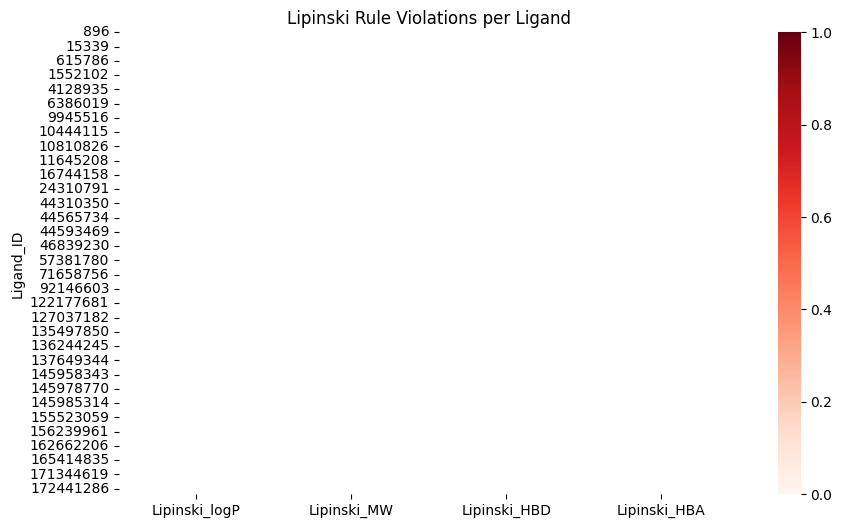

In [21]:
# Step 22: Heatmap 
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap of violations
violation_cols = ['Lipinski_logP', 'Lipinski_MW', 'Lipinski_HBD', 'Lipinski_HBA']
violation_matrix = ~df[violation_cols]  # invert to get violations as True
violation_matrix.index = df['Ligand_ID']

plt.figure(figsize=(10,6))
sns.heatmap(violation_matrix, cmap='Reds', cbar=True, linewidths=0.5)
plt.title("Lipinski Rule Violations per Ligand")
plt.savefig("lipinski_violations_heatmap.png")
plt.show()


In [22]:
# Step 23. Filter Ligands with ≤1 Violation
filtered_df = df[df['Lipinski_Violations'] <= 1]
filtered_df.to_csv("ligands_filtered_partial_pass.csv", index=False)


In [23]:
#Step 24: Random Forest Classifier to Predict Lipinski Compliance

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define features and target
feature_cols = ['logP', 'MW', 'TPSA', 'HBD', 'HBA', 'RotatableBonds']
X = df[feature_cols]
y = df['Lipinski_Pass'].astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       1.00      1.00      1.00       506

    accuracy                           1.00       525
   macro avg       1.00      0.97      0.99       525
weighted avg       1.00      1.00      1.00       525



In [24]:
# Step 25 – Predict Lipinski Compliance for All Ligands

# Predict probabilities of Lipinski compliance (1 = pass)
df['Lipinski_Pred_Prob'] = clf.predict_proba(X)[:, 1]

# Also store model prediction (0 or 1)
df['Lipinski_Pred'] = clf.predict(X)

# Save with predictions
df.to_csv("ligands_with_predicted_lipinski_scores.csv", index=False)

print("✅ Saved: ligands_with_predicted_lipinski_scores.csv")


✅ Saved: ligands_with_predicted_lipinski_scores.csv


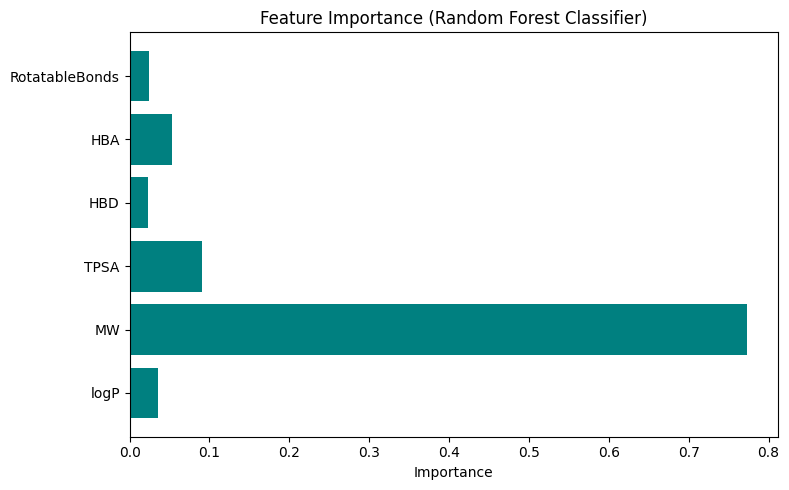

In [25]:
# Step 26 – Feature Importance Plot

import matplotlib.pyplot as plt

# Get feature importances
importances = clf.feature_importances_
feature_names = X.columns

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color='teal')
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest Classifier)")
plt.tight_layout()
plt.savefig("feature_importance_rf.png")
plt.show()


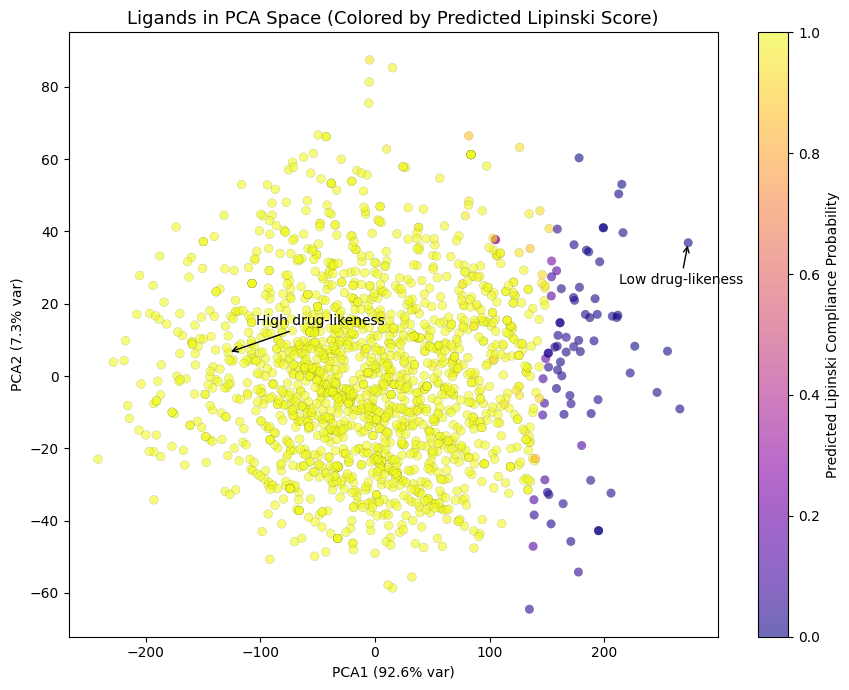

In [26]:
# Step 27 – Enhanced PCA Plot of Ligand Feature Space

# Import required libraries
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce feature space to 2D using PCA
pca = PCA(n_components=2)  # Set number of components to 2 for 2D visualization
X_pca = pca.fit_transform(X)  # Fit and transform the feature matrix X

# Add PCA components to original dataframe for plotting
df['PCA1'] = X_pca[:, 0]  # First principal component
df['PCA2'] = X_pca[:, 1]  # Second principal component

# Calculate how much variance each PCA component explains (for axis labeling)
explained_var = pca.explained_variance_ratio_ * 100  # Convert to percentage
pca1_label = f"PCA1 ({explained_var[0]:.1f}% var)"  # e.g., PCA1 (94.1% var)
pca2_label = f"PCA2 ({explained_var[1]:.1f}% var)"  # e.g., PCA2 (5.9% var)

# Plot PCA results in 2D with color indicating predicted Lipinski compliance
plt.figure(figsize=(9,7))  # Set plot size
scatter = plt.scatter(
    df['PCA1'], 
    df['PCA2'], 
    c=df['Lipinski_Pred_Prob'],       # Color by predicted Lipinski probability
    cmap='plasma',                    # Use a vivid purple-to-yellow colormap
    s=40,                             # Dot size
    alpha=0.6,                        # Make dots slightly transparent
    edgecolors='k', linewidth=0.1     # Thin black edge for better visibility
)

# Add a colorbar to explain the meaning of colors
cbar = plt.colorbar(scatter)
cbar.set_label('Predicted Lipinski Compliance Probability')  # Label the colorbar

# Add plot title and axis labels
plt.title("Ligands in PCA Space (Colored by Predicted Lipinski Score)", fontsize=13)
plt.xlabel(pca1_label)
plt.ylabel(pca2_label)

# Annotate a high- and low-scoring ligand for interpretability
# Pick one ligand with very high predicted score
high_ligand = df[df['Lipinski_Pred_Prob'] > 0.99].iloc[0]
# Pick one ligand with very low predicted score
low_ligand = df[df['Lipinski_Pred_Prob'] < 0.01].iloc[0]

# Add annotation for high drug-likeness
plt.annotate("High drug-likeness", 
             (high_ligand['PCA1'], high_ligand['PCA2']),
             xytext=(20,20), textcoords='offset points',
             arrowprops=dict(arrowstyle='->'))

# Add annotation for low drug-likeness
plt.annotate("Low drug-likeness", 
             (low_ligand['PCA1'], low_ligand['PCA2']),
             xytext=(-50,-30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->'))

# Save the figure and display it
plt.tight_layout()  # Adjust spacing to avoid label cutoff
plt.savefig("pca_ligands_lipinski_score.png", dpi=300)  # Save as high-res PNG
plt.show()  # Display the final plot



In [27]:
# Step 28 – Rank Ligands by Predicted Lipinski Score

# Sort ligands by model-predicted probability of compliance
ranked_ligands = df.sort_values(by='Lipinski_Pred_Prob', ascending=False)

# Save top ligands with only available columns
ranked_ligands[['Ligand_ID', 'Lipinski_Pred_Prob']].head(20).to_csv(
    "top20_ligands_by_ml_score.csv", index=False
)

print("✅ Saved: top20_ligands_by_ml_score.csv")


✅ Saved: top20_ligands_by_ml_score.csv


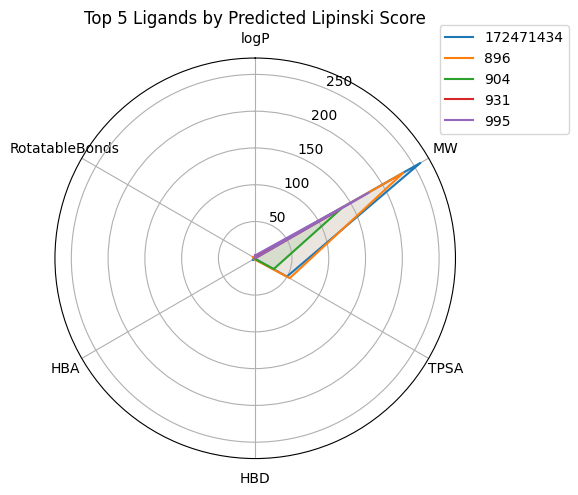

In [28]:
# Step 29 – Visualize Top Ligands (Optional Radar Plot)

# (Optional) Radar plot again but for top 5 ML-ranked ligands
top5 = ranked_ligands.head(5)
labels = ['logP', 'MW', 'TPSA', 'HBD', 'HBA', 'RotatableBonds']
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
for idx, row in top5.iterrows():
    values = [row[label] for label in labels]
    values += values[:1]
    ax.plot(angles, values, label=row['Ligand_ID'])
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title("Top 5 Ligands by Predicted Lipinski Score")
plt.tight_layout()
plt.savefig("radar_top5_ml_ligands.png")
plt.show()


In [29]:
# === Build pubchem_ligand_dict from SDFs ===
from rdkit import Chem
import os

pubchem_ligand_dict = {}  # Create dictionary to hold ligands

for sdf_file in os.listdir(pubchem_folder):
    if sdf_file.endswith(".sdf"):
        sdf_path = os.path.join(pubchem_folder, sdf_file)
        suppl = Chem.SDMolSupplier(sdf_path, removeHs=False)
        for mol in suppl:
            if mol is None:
                continue
            lig_id = mol.GetProp("_Name") if mol.HasProp("_Name") else sdf_file.split('.')[0]
            if mol.GetNumHeavyAtoms() > 0:
                pubchem_ligand_dict[lig_id] = mol

print(f"✅ Loaded {len(pubchem_ligand_dict)} PubChem ligands into dictionary.")


✅ Loaded 2454 PubChem ligands into dictionary.



--- Step 30: Visualise Top 5 Lipinski-Compliant Ligands ---
These ligands passed Lipinski filtering and were ranked highly by the ML model.

Visualising the top 5 predicted ligands with formula and Lipinski descriptors...



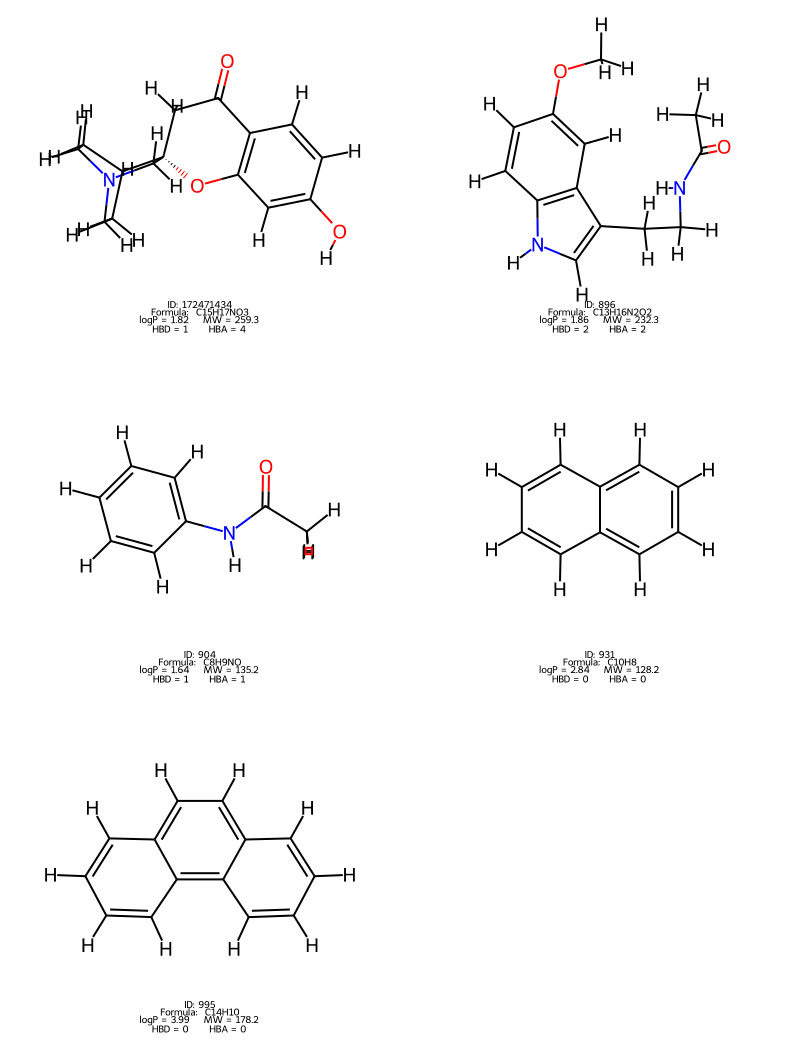

In [30]:
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors

print("\n--- Step 30: Visualise Top 5 Lipinski-Compliant Ligands ---")
print("These ligands passed Lipinski filtering and were ranked highly by the ML model.\n")

top5 = ranked_ligands.head(5)
top5_ids = top5['Ligand_ID'].astype(str).tolist()

top5_mols = [pubchem_ligand_dict[lig_id] for lig_id in top5_ids if lig_id in pubchem_ligand_dict]

# Create spaced-out legends
legends = []
for lig_id in top5_ids:
    mol = pubchem_ligand_dict.get(lig_id)
    if mol:
        formula = rdMolDescriptors.CalcMolFormula(mol)
        row = top5[top5['Ligand_ID'].astype(str) == lig_id]
        if not row.empty:
            logP = round(row['logP'].values[0], 2)
            MW = round(row['MW'].values[0], 1)
            HBD = int(row['HBD'].values[0])
            HBA = int(row['HBA'].values[0])

            # Nicely spaced layout
            legend = (
                f"ID: {lig_id}\n"
                f"Formula:  {formula}\n\n"
                f"logP = {logP:<5}   MW = {MW:<6}\n"
                f"HBD = {HBD:<2}     HBA = {HBA:<2}"
            )
        else:
            legend = f"ID: {lig_id}\nFormula:  {formula}"
        legends.append(legend)
    else:
        legends.append(f"ID: {lig_id}")


# Display molecules side-by-side with better spacing
if top5_mols:
    print("Visualising the top 5 predicted ligands with formula and Lipinski descriptors...\n")
    img = Draw.MolsToGridImage(
        top5_mols,
        molsPerRow=2,
        subImgSize=(400, 350),  # Slightly taller for room
        legends=legends,
        useSVG=True
    )
    display(img)
else:
    print("⚠️ No ligands matched between top 5 IDs and pubchem_ligand_dict.")




In [31]:
# Final Export

# Export entire updated dataframe with scores and PCA info
df.to_csv("final_ligand_predictions_with_PCA.csv", index=False)
print("✅ Pipeline Complete – Final output saved as: final_ligand_predictions_with_PCA.csv")


✅ Pipeline Complete – Final output saved as: final_ligand_predictions_with_PCA.csv
